# 0.0 IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
import tabulate

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed ( range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k) )
        # start and end date for validation
        validation_start_date = x_training['date'].max - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        trainig = x_trainig[ x_trainig['date'] < validation_start_date]
        validation = x_trainig[ (x_trainig['date'] < validation_start_date) &  (x_trainig['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = training.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat_lr = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_lr))
        
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        
    return pd.DataFrame( {'Model Name': model_name, 
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+\-' + np.round( np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+\-' + np.round( np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+\-' + np.round( np.std(rmse_list), 2).astype(str)}, index=[0] )

def mean_absolute_percent_error(y, yhat):
  return np.mean(np.abs((y - yhat) / y))


def ml_error( model_name, y, yhat):
  mae = mean_absolute_error( y, yhat )
  mape = mean_absolute_percent_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse }, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r,k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    # %pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container (width:100% !important;)</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
868543,744,2,2013-05-14,8606,900,1,1,0,0,a,a,1370.0,12.0,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0 PASSO 01 -

## 1.1. Rename Columns

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old))

# cols_new = list( map

#rename
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))


Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [11]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
# competition_distance
df1['competition_distance']= df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month']= df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year']= df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week']= df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )


# promo2_since_year
df1['promo2_since_year']= df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

## 1.6. Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


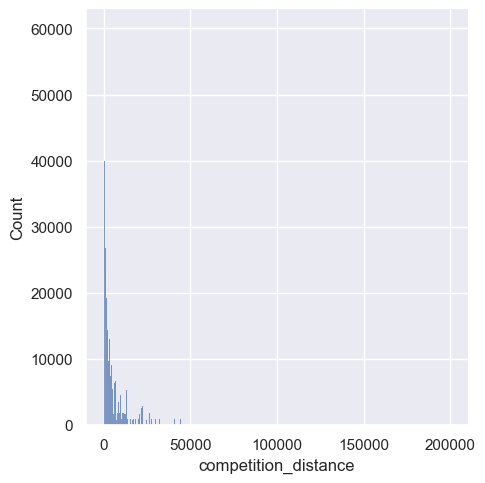

In [19]:
sns.displot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

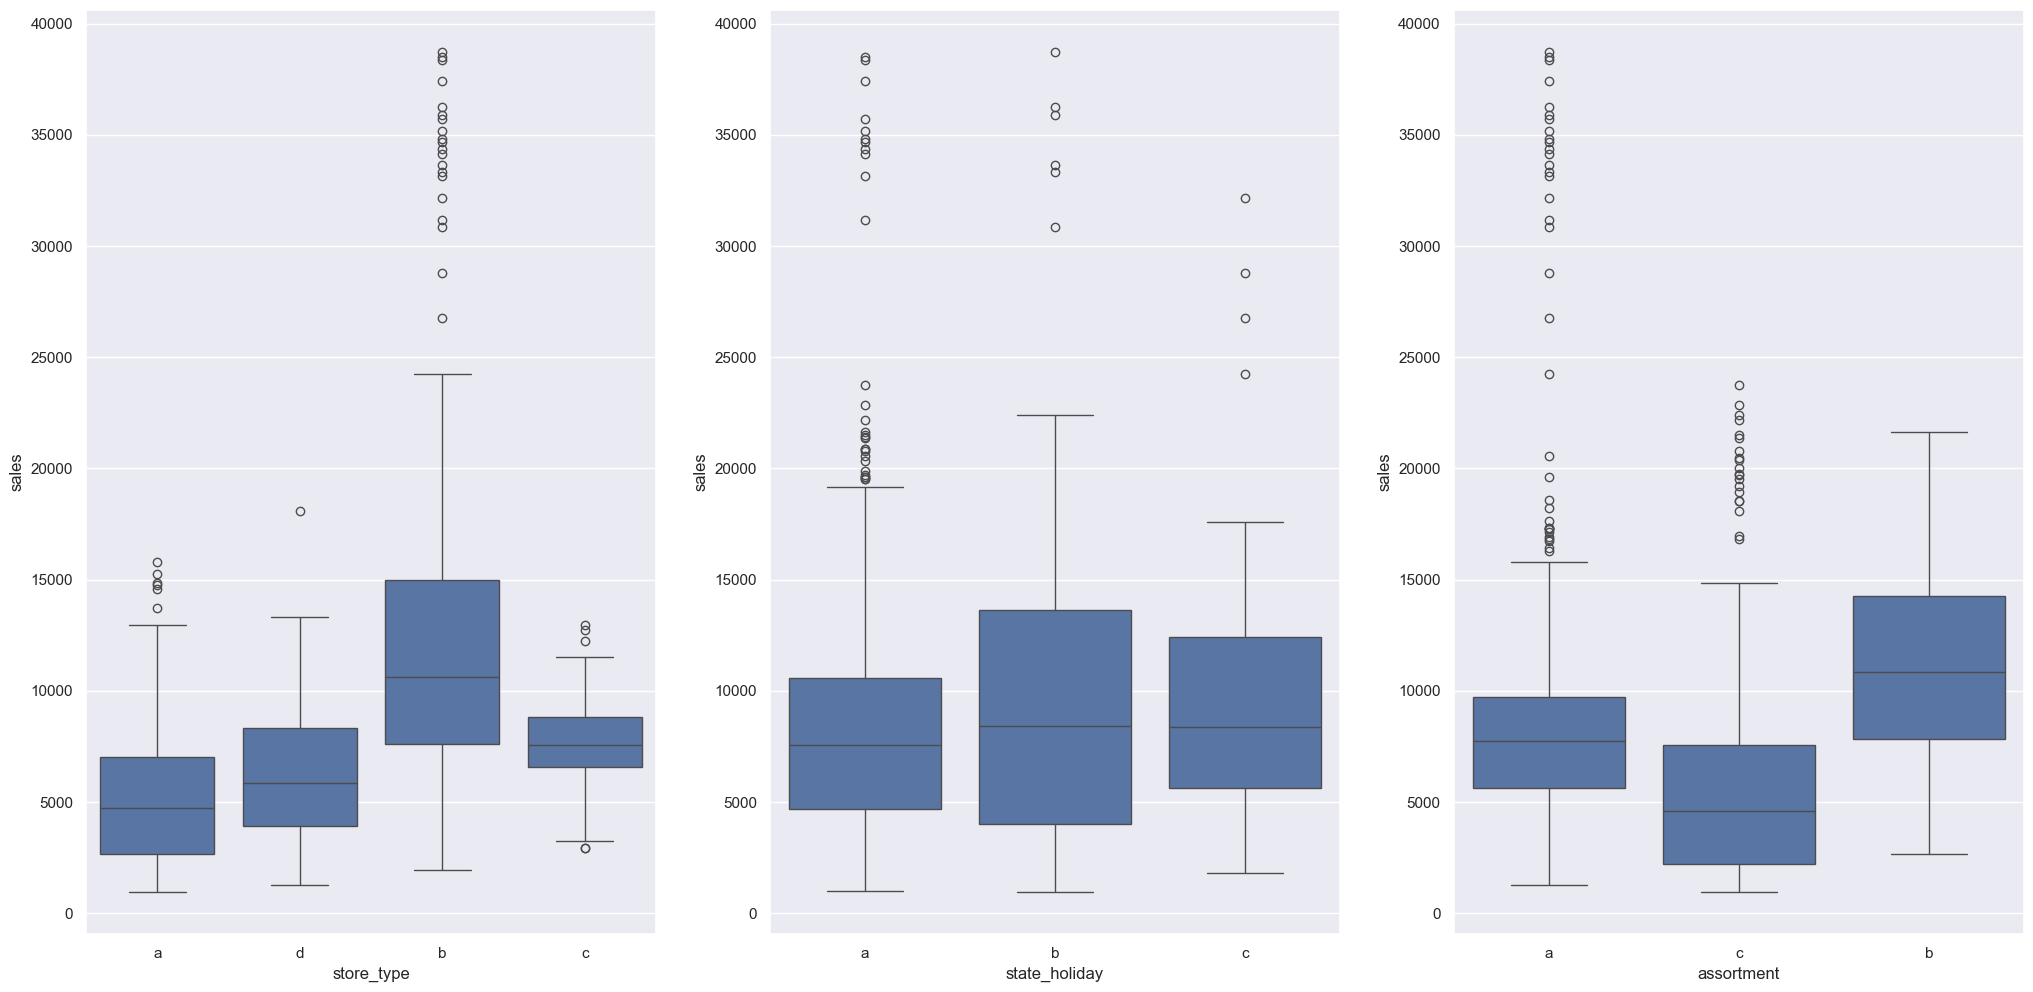

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & ( df1['sales'] >0 )]

plt.subplot(1, 3, 1)
sns.boxplot( x='store_type', y= 'sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='state_holiday', y= 'sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y= 'sales', data=aux1 )


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipotesis

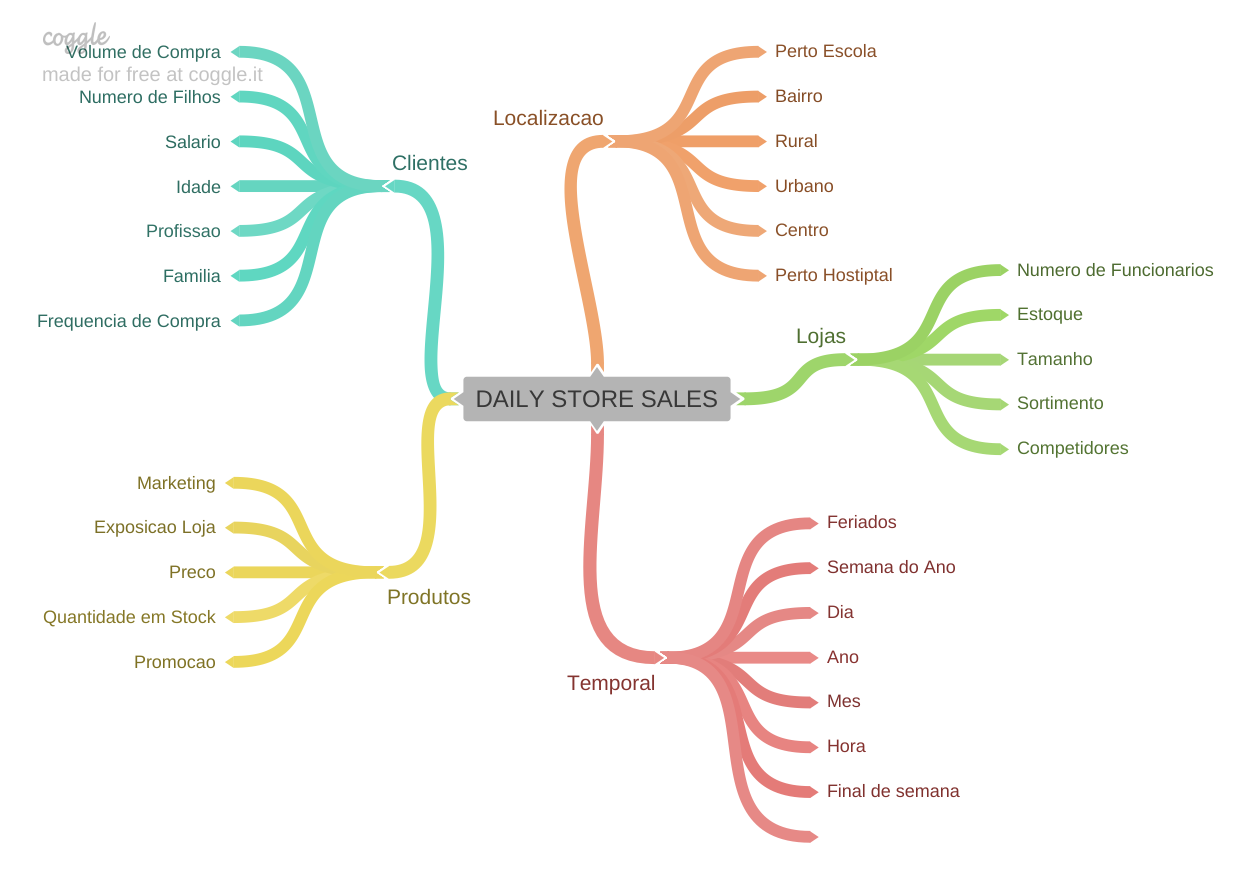

In [23]:
Image('img/MindMapllypothesis.png')

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais.


### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vendermais.


### 2.2.3. Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam venderi mais no segundo semestre do ano.

**10.** Lojas deveriam vender maisdepois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos duranteo os feriados escolares.

## 2.3. Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# wek of year
df2['week_of_year'] = df2['date'].dt.strftime( '%W')

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month']= ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype('int64')

# assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'extended' if x == 'c' else 'regular_day' )



In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,30,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,30,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,30,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,30,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,30,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [28]:
df3= df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.2. Selecao das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1. Analise Univariada

## 4.1.1. Response Variable

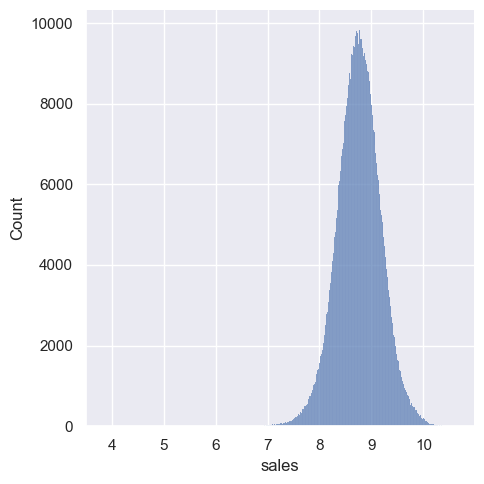

In [31]:
sns.displot(np.log1p(df4['sales']))

## 4.1.2. Numerical Variable

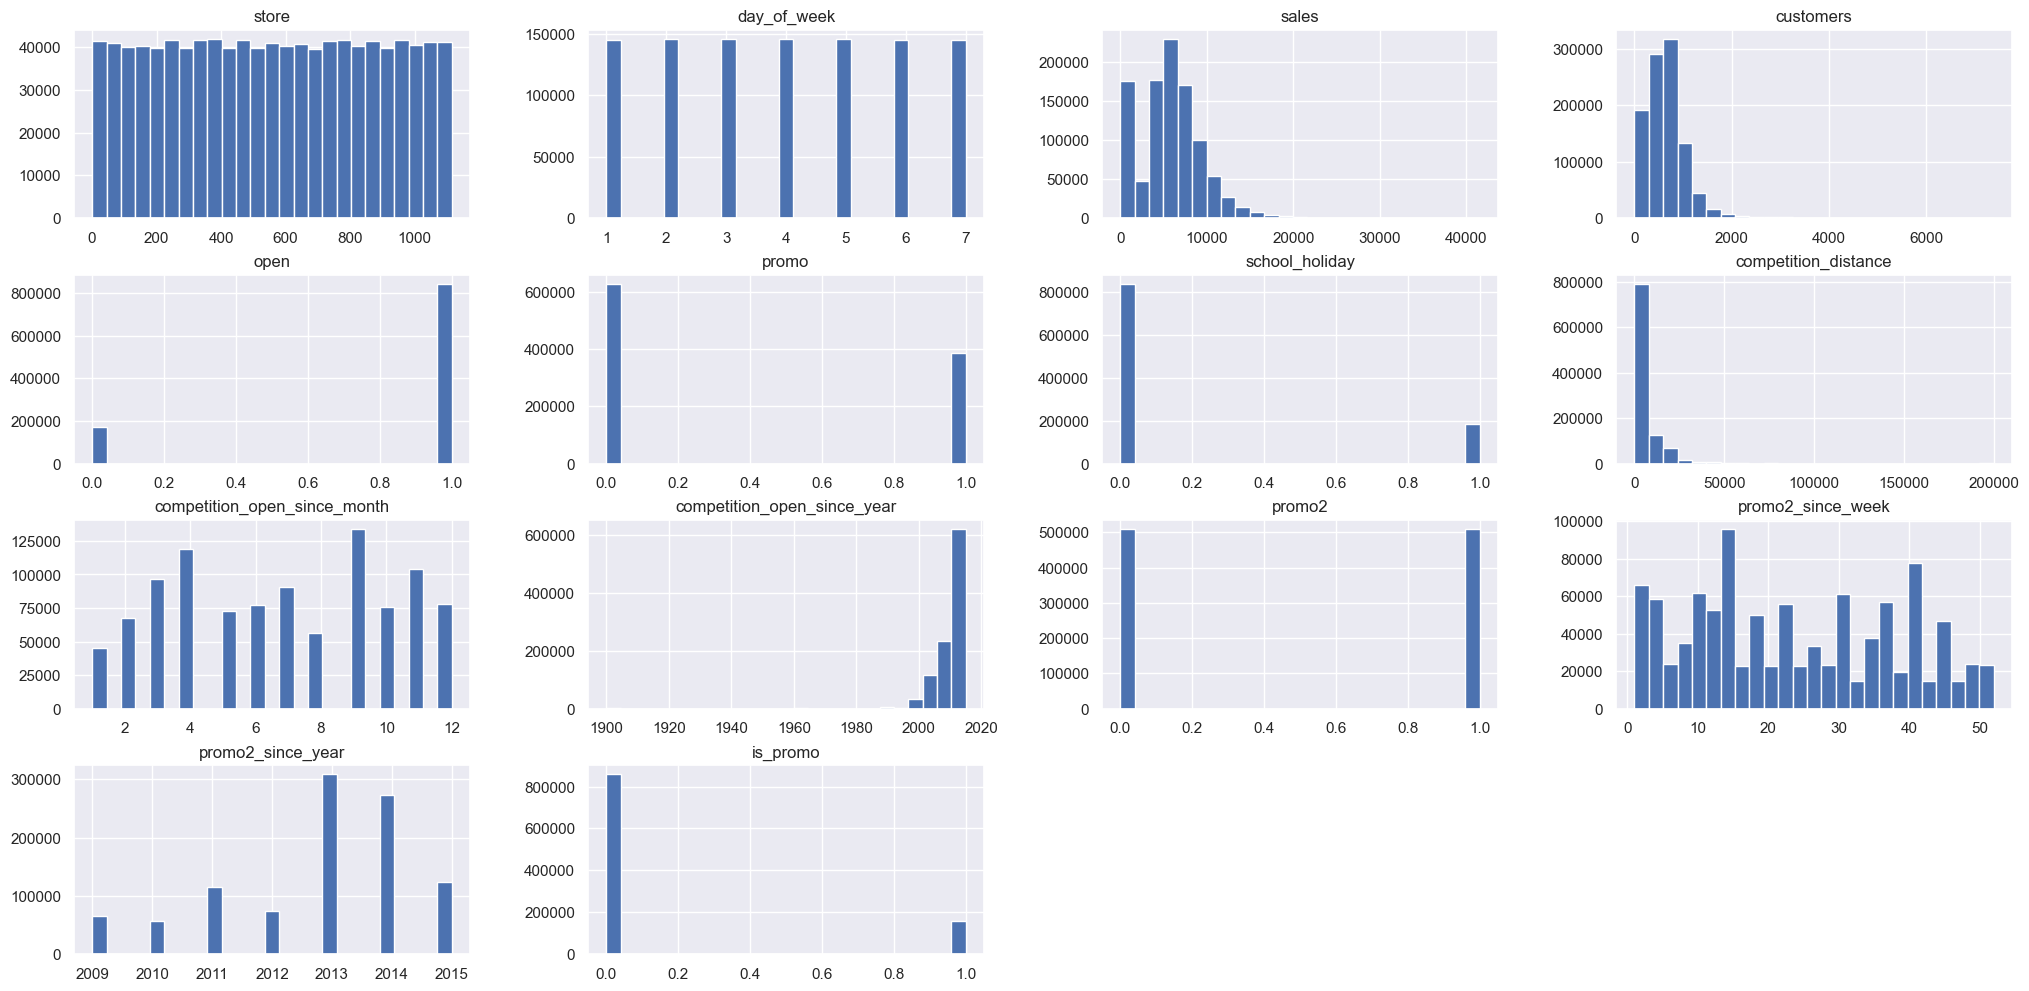

In [32]:
num_attributes.hist(bins=25);

## 4.1.2. Categorical Variable

In [33]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126          extended
Name: state_holiday, dtype: object

C:\Users\guilherme_cds\AppData\Local\Temp\ipykernel_19424\2619702859.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
C:\Users\guilherme_cds\AppData\Local\Temp\ipykernel_19424\2619702859.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
C:\Users\guilherme_cds\AppData\Local\Temp\ipykernel_19424\2619702859.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'chistmas']['sales'], label='chistmas', shade=True)
C

<Axes: xlabel='sales', ylabel='Density'>

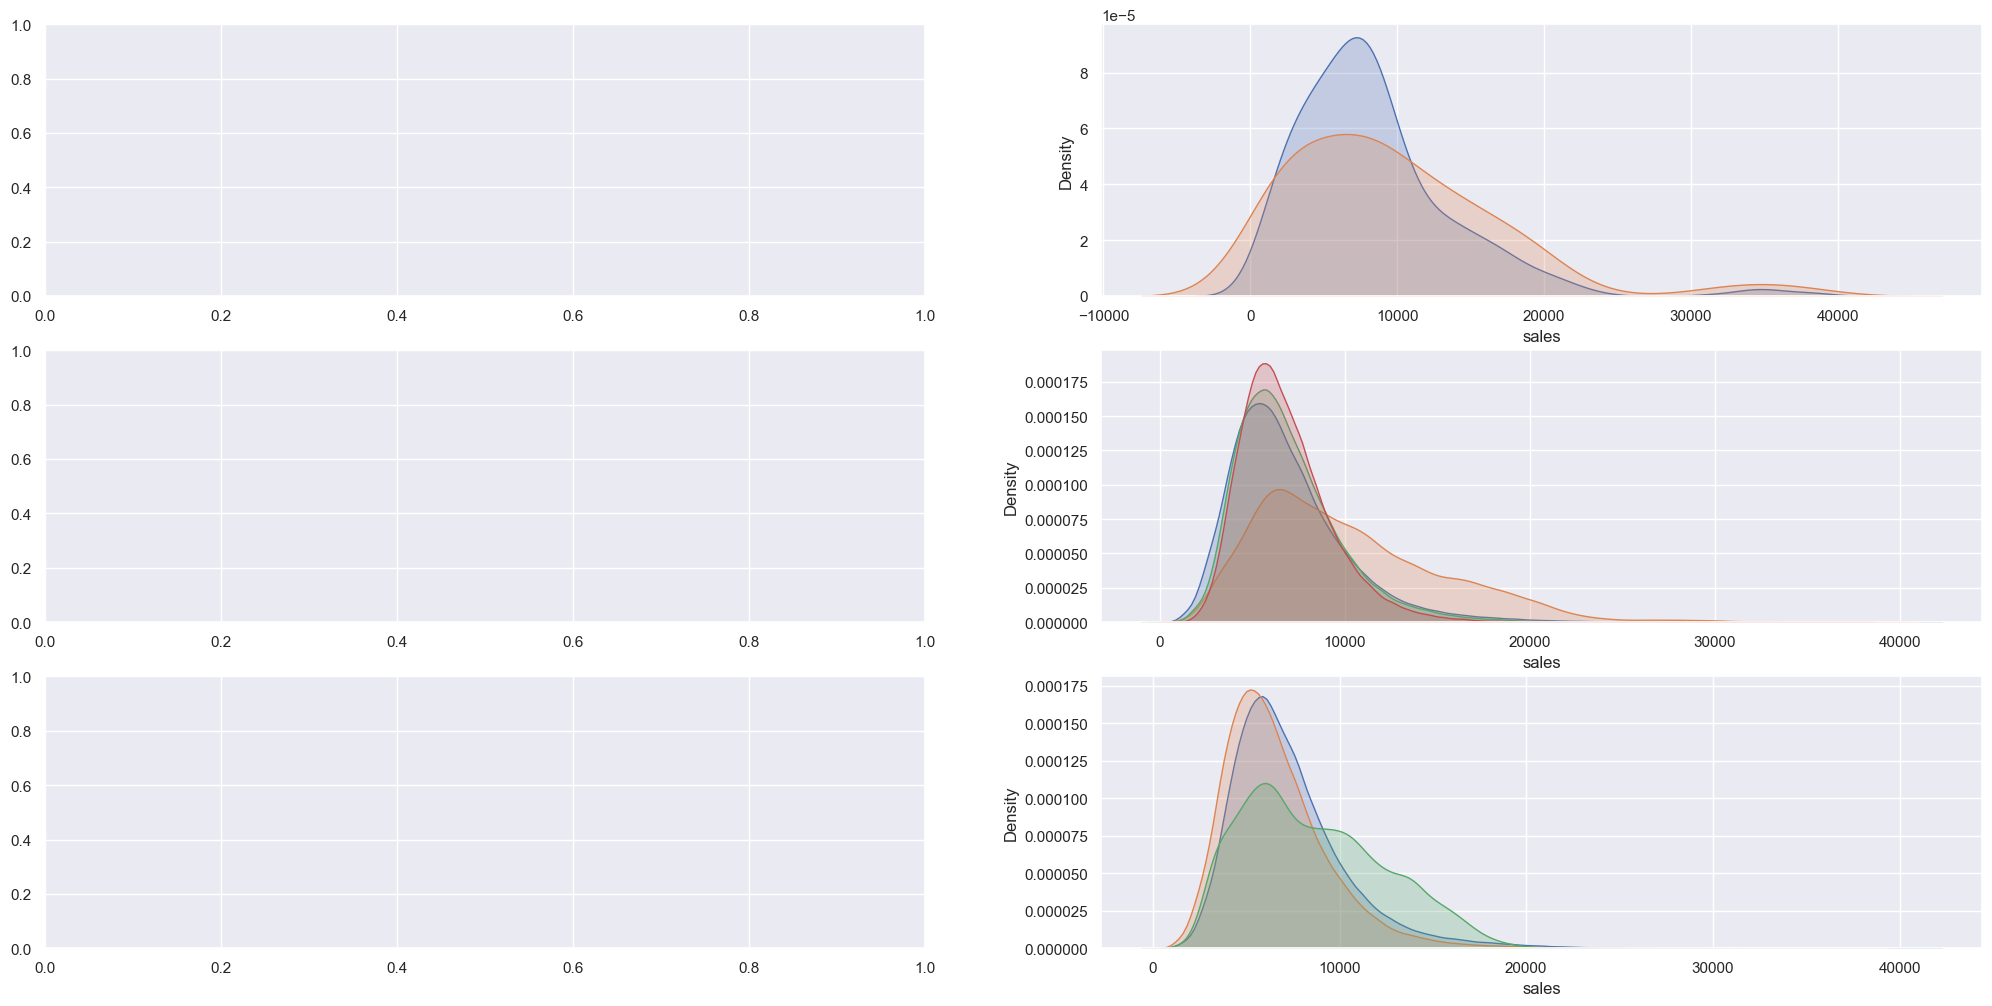

In [34]:
# state_holiday
plt.subplot (3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
# sns.countplot(a['state_holiday'])

plt.subplot (3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'chistmas']['sales'], label='chistmas', shade=True)

# store_type

plt.subplot (3,2,3)
# sns.countplot(df4['store_type'])

plt.subplot (3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment

plt.subplot (3,2,5)
# sns.countplot(df4['assortment'])

plt.subplot (3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.

**Falsa** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

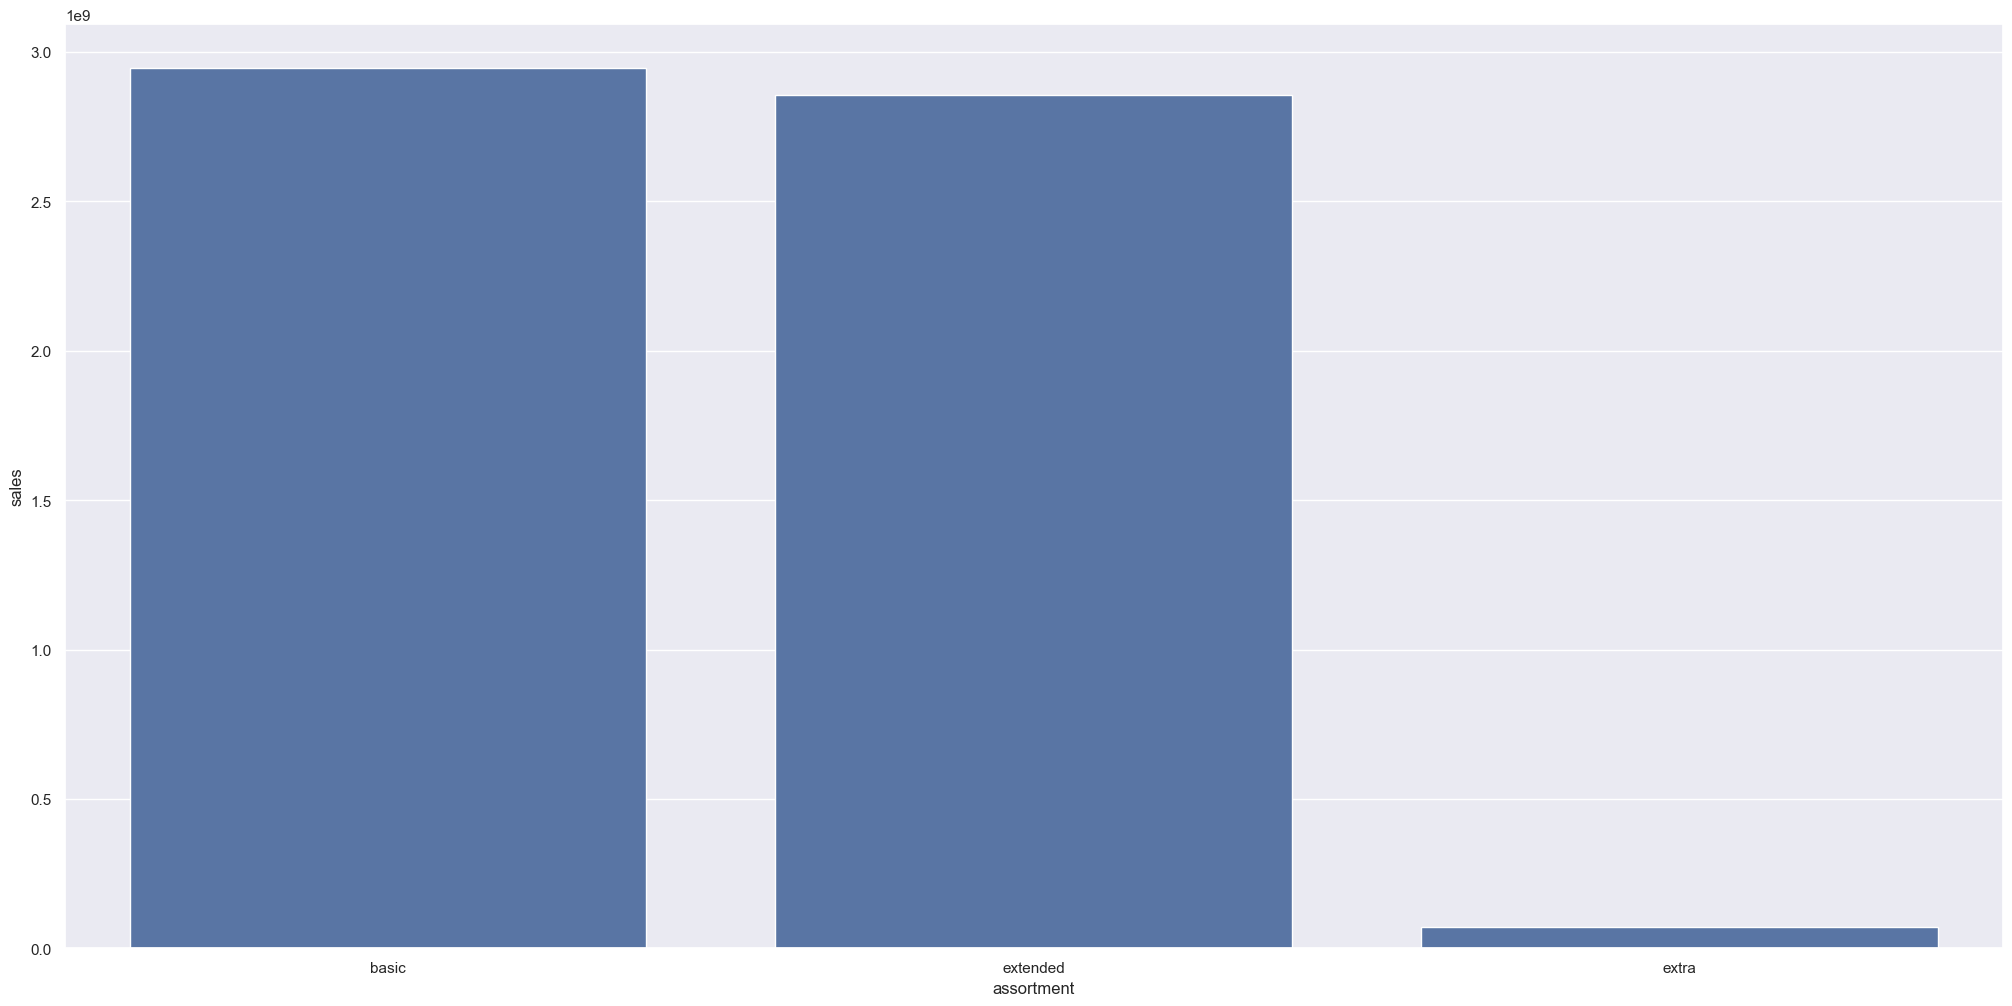

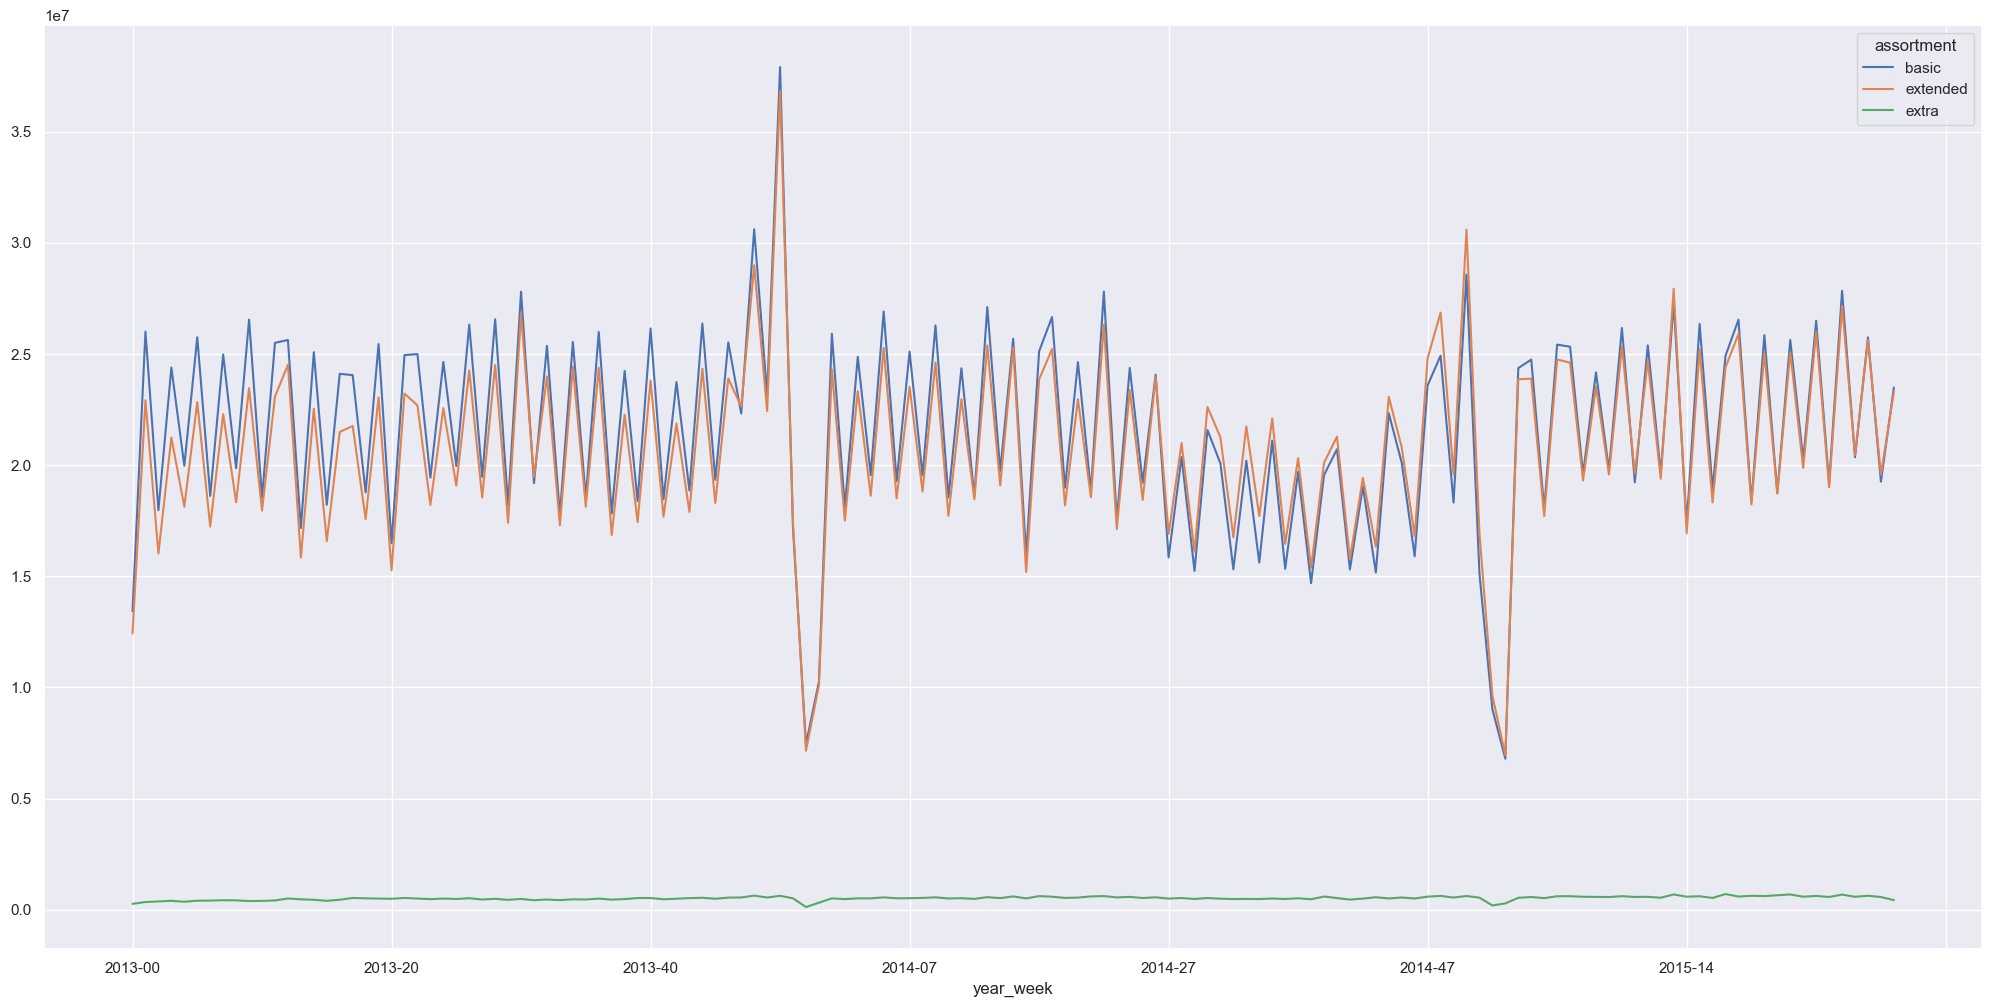

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values= 'sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSO**  Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

C:\Users\guilherme_cds\AppData\Local\Temp\ipykernel_19424\2748282725.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


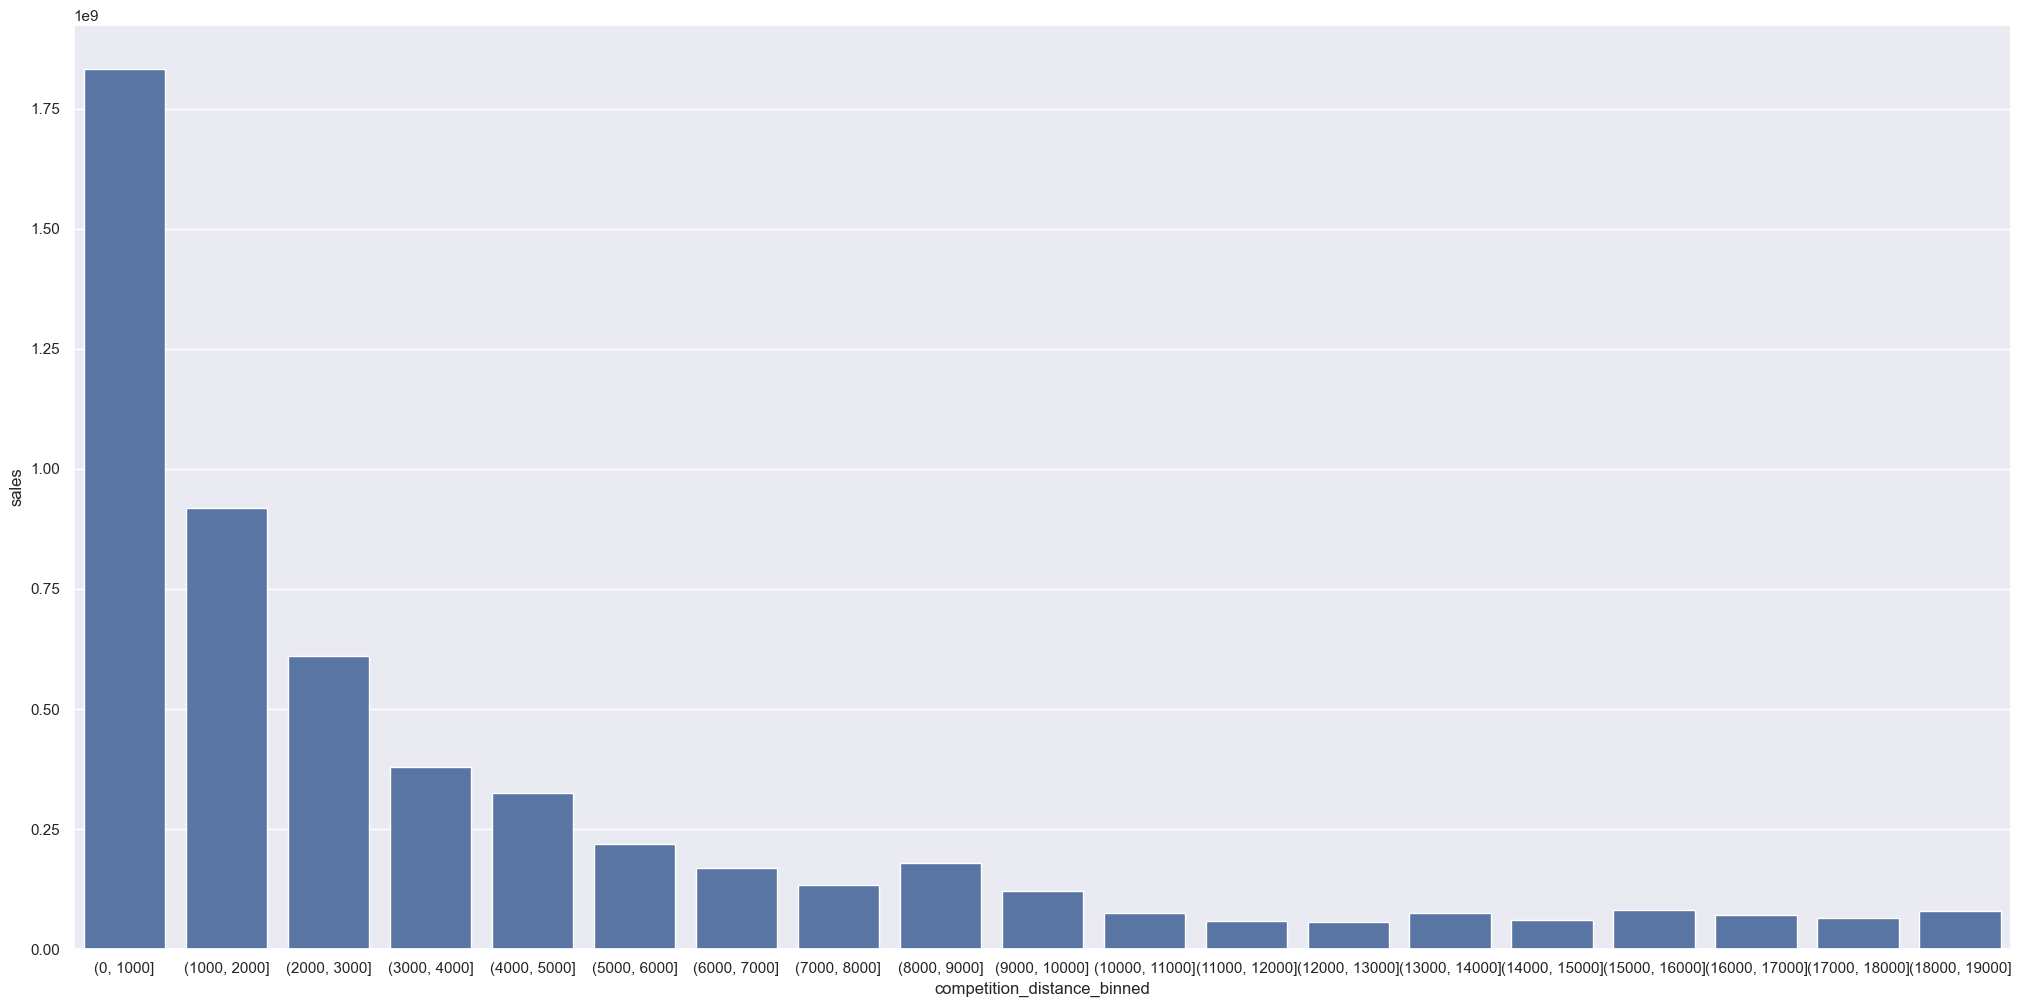

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

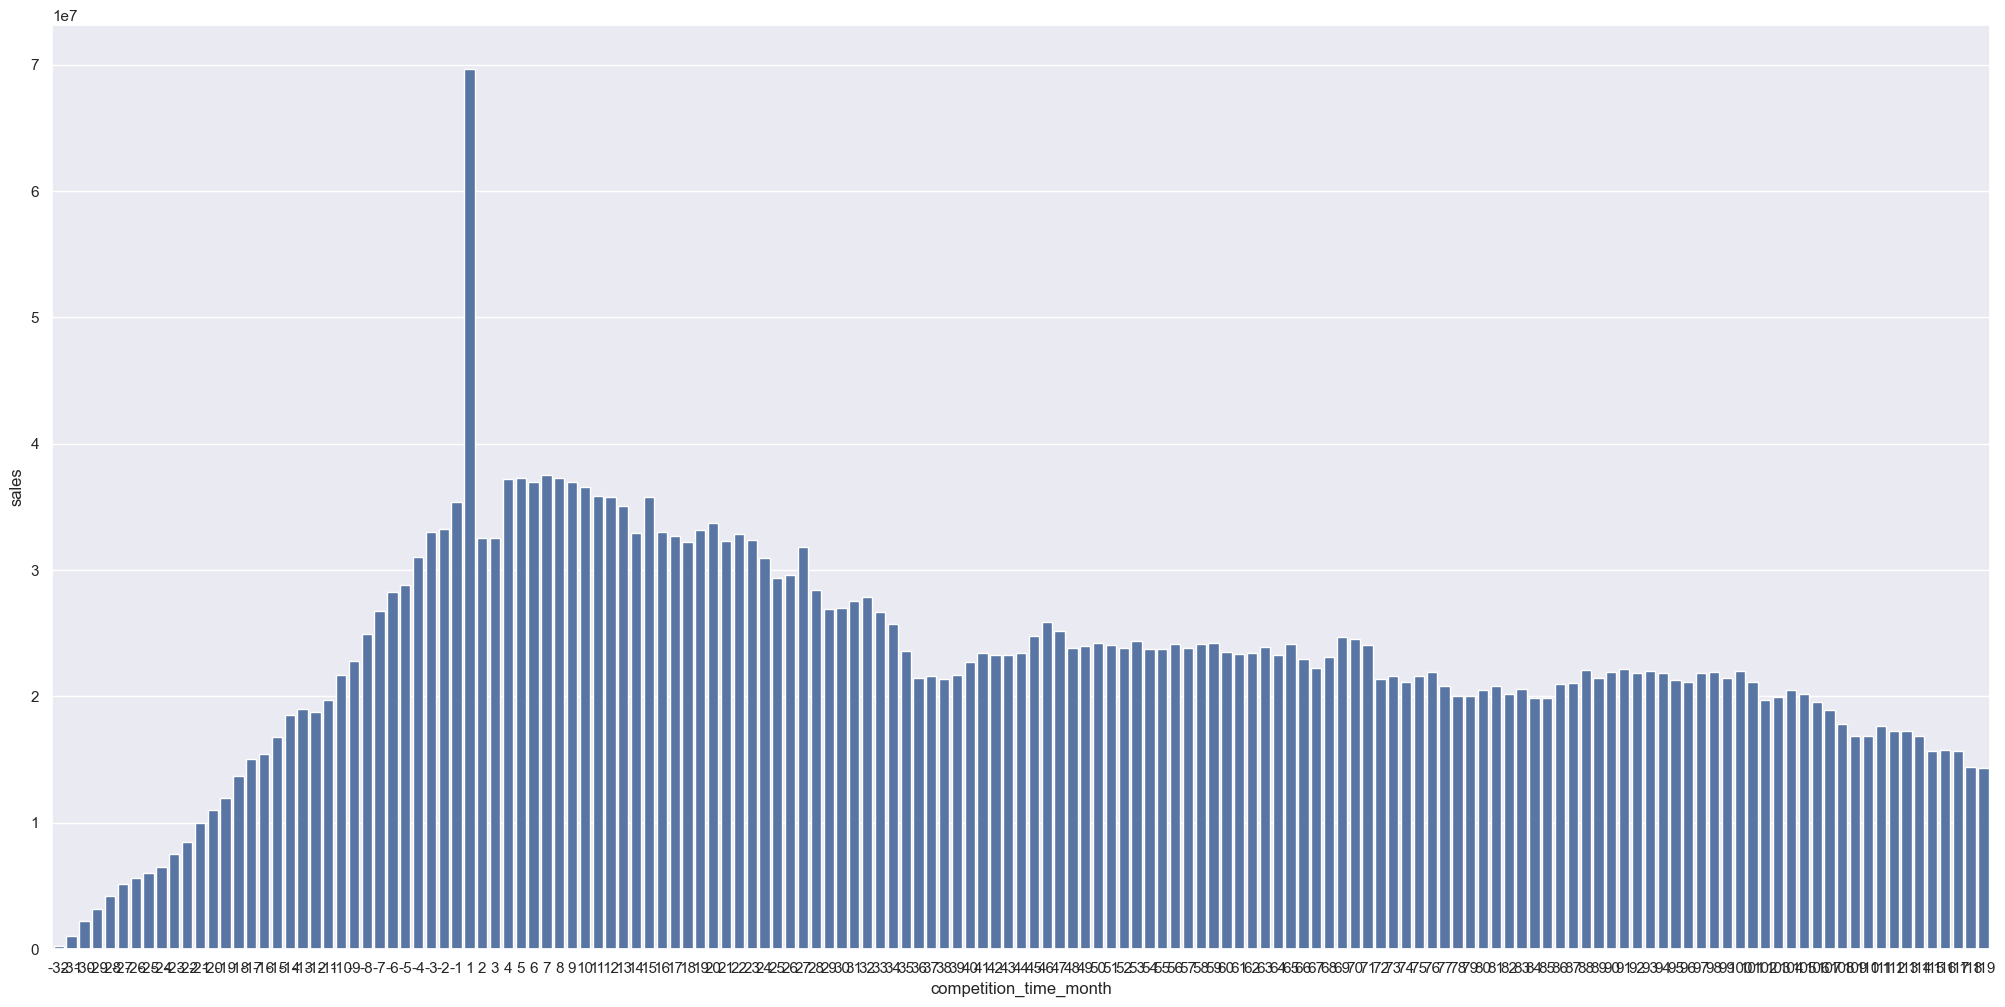

In [37]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

sns.barplot( x='competition_time_month', y='sales', data=aux2 );

In [38]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de competição.

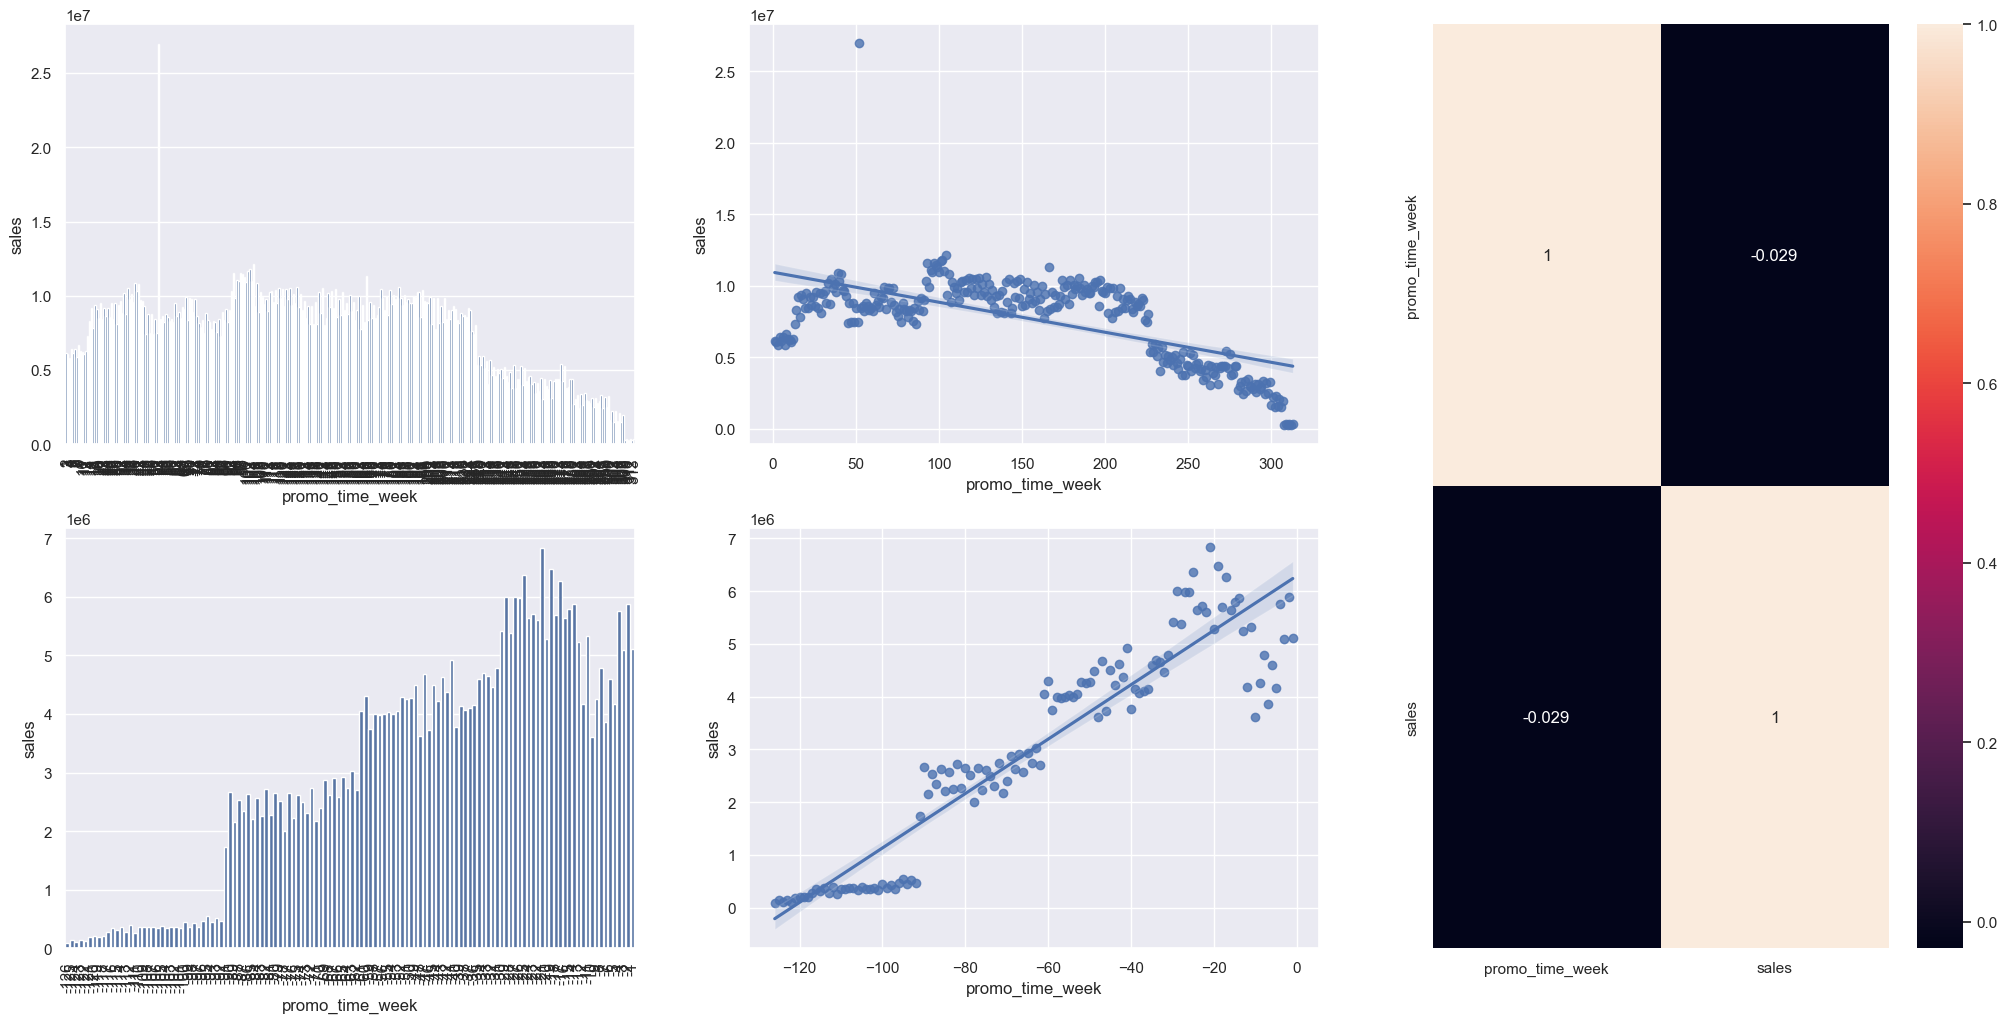

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation = 90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2 );


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation = 90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [40]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


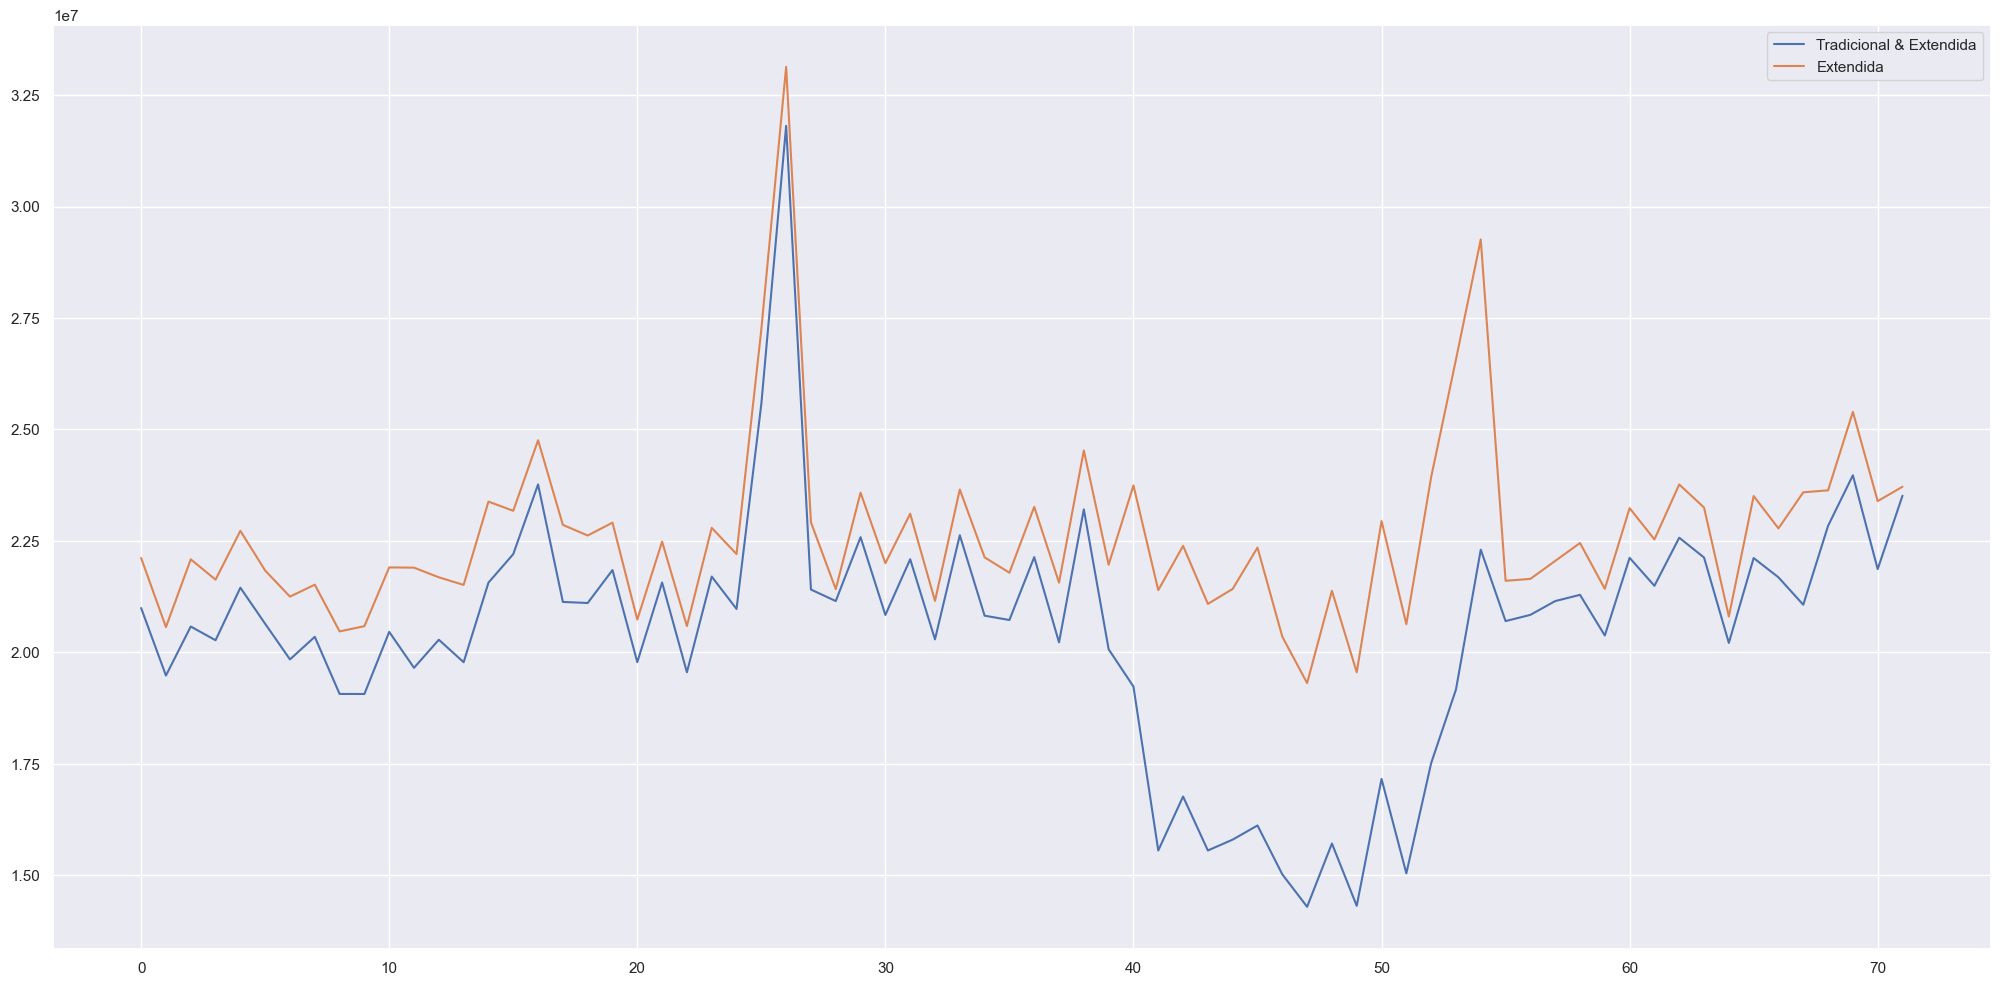

In [41]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)] [['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)] [['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida'])

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA**  Lojas abertas durante o feriado do Natal vendem menos.

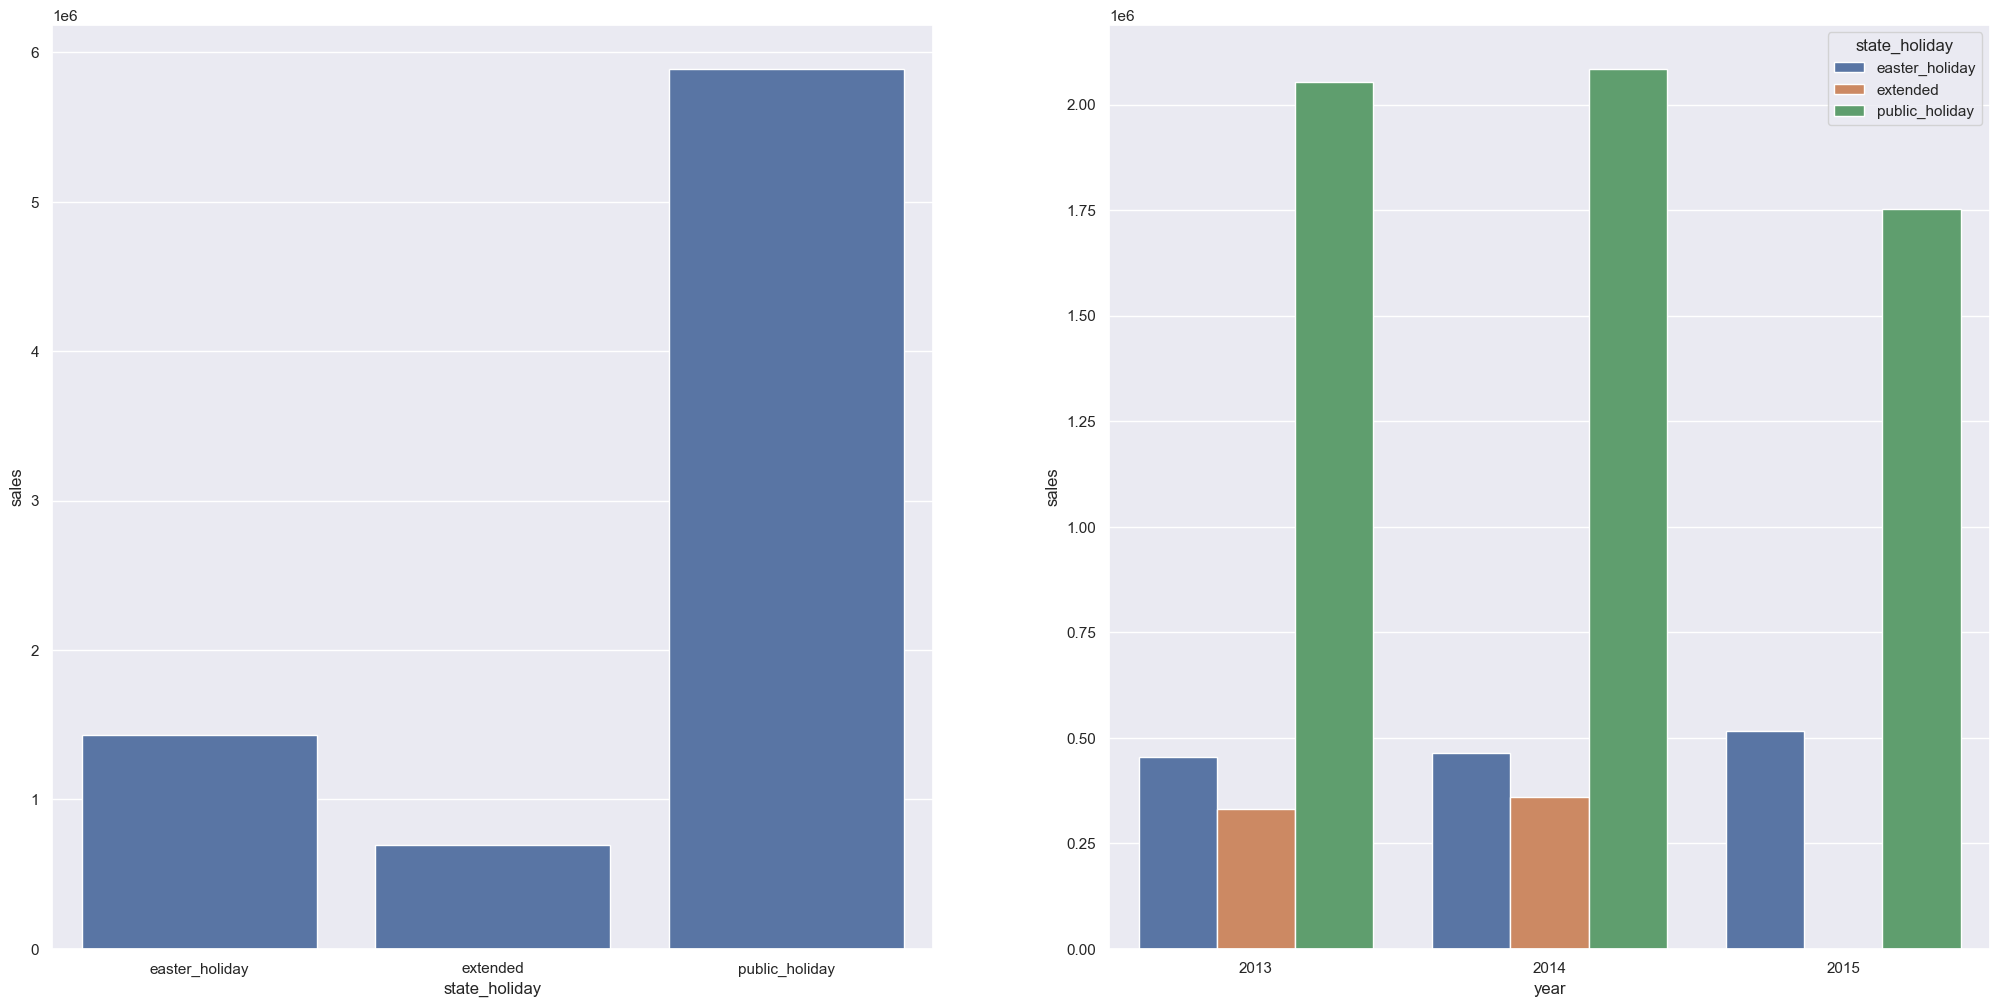

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA**  Lojas vendem menos ao longo dos anos

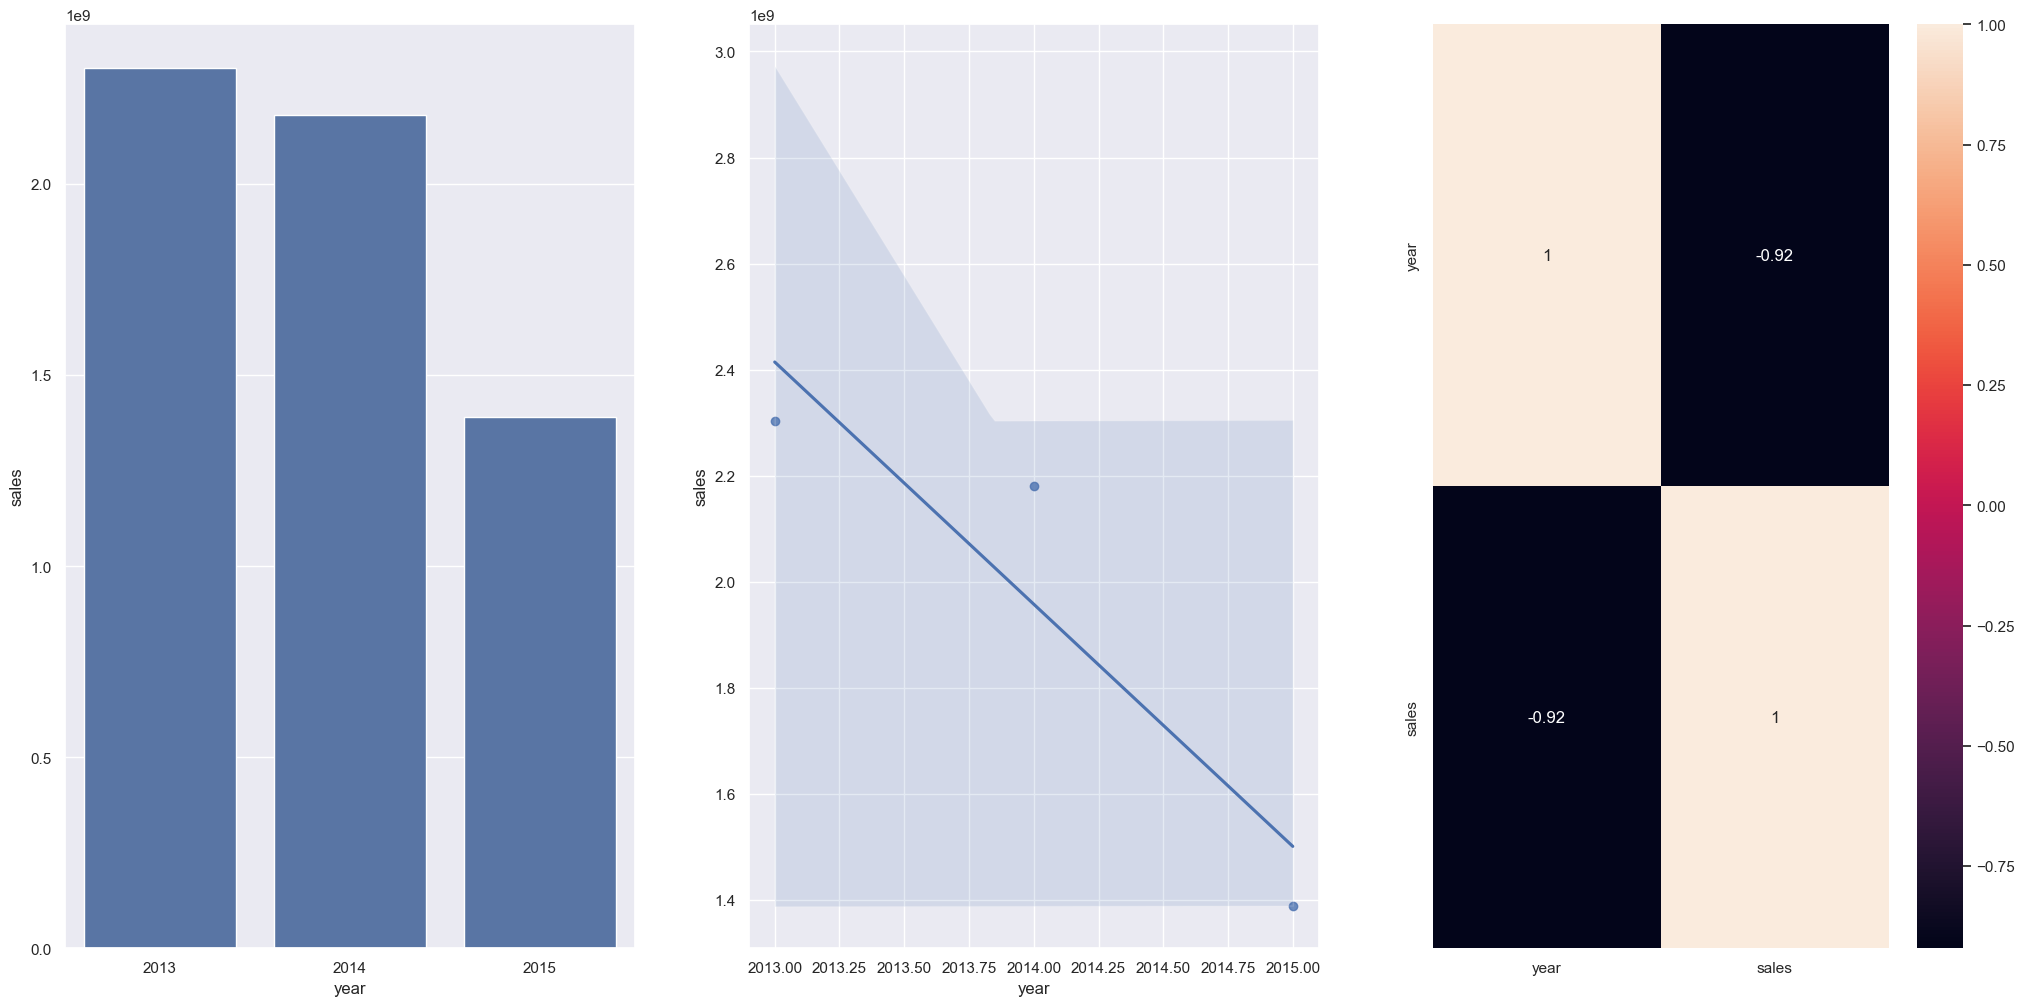

In [43]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

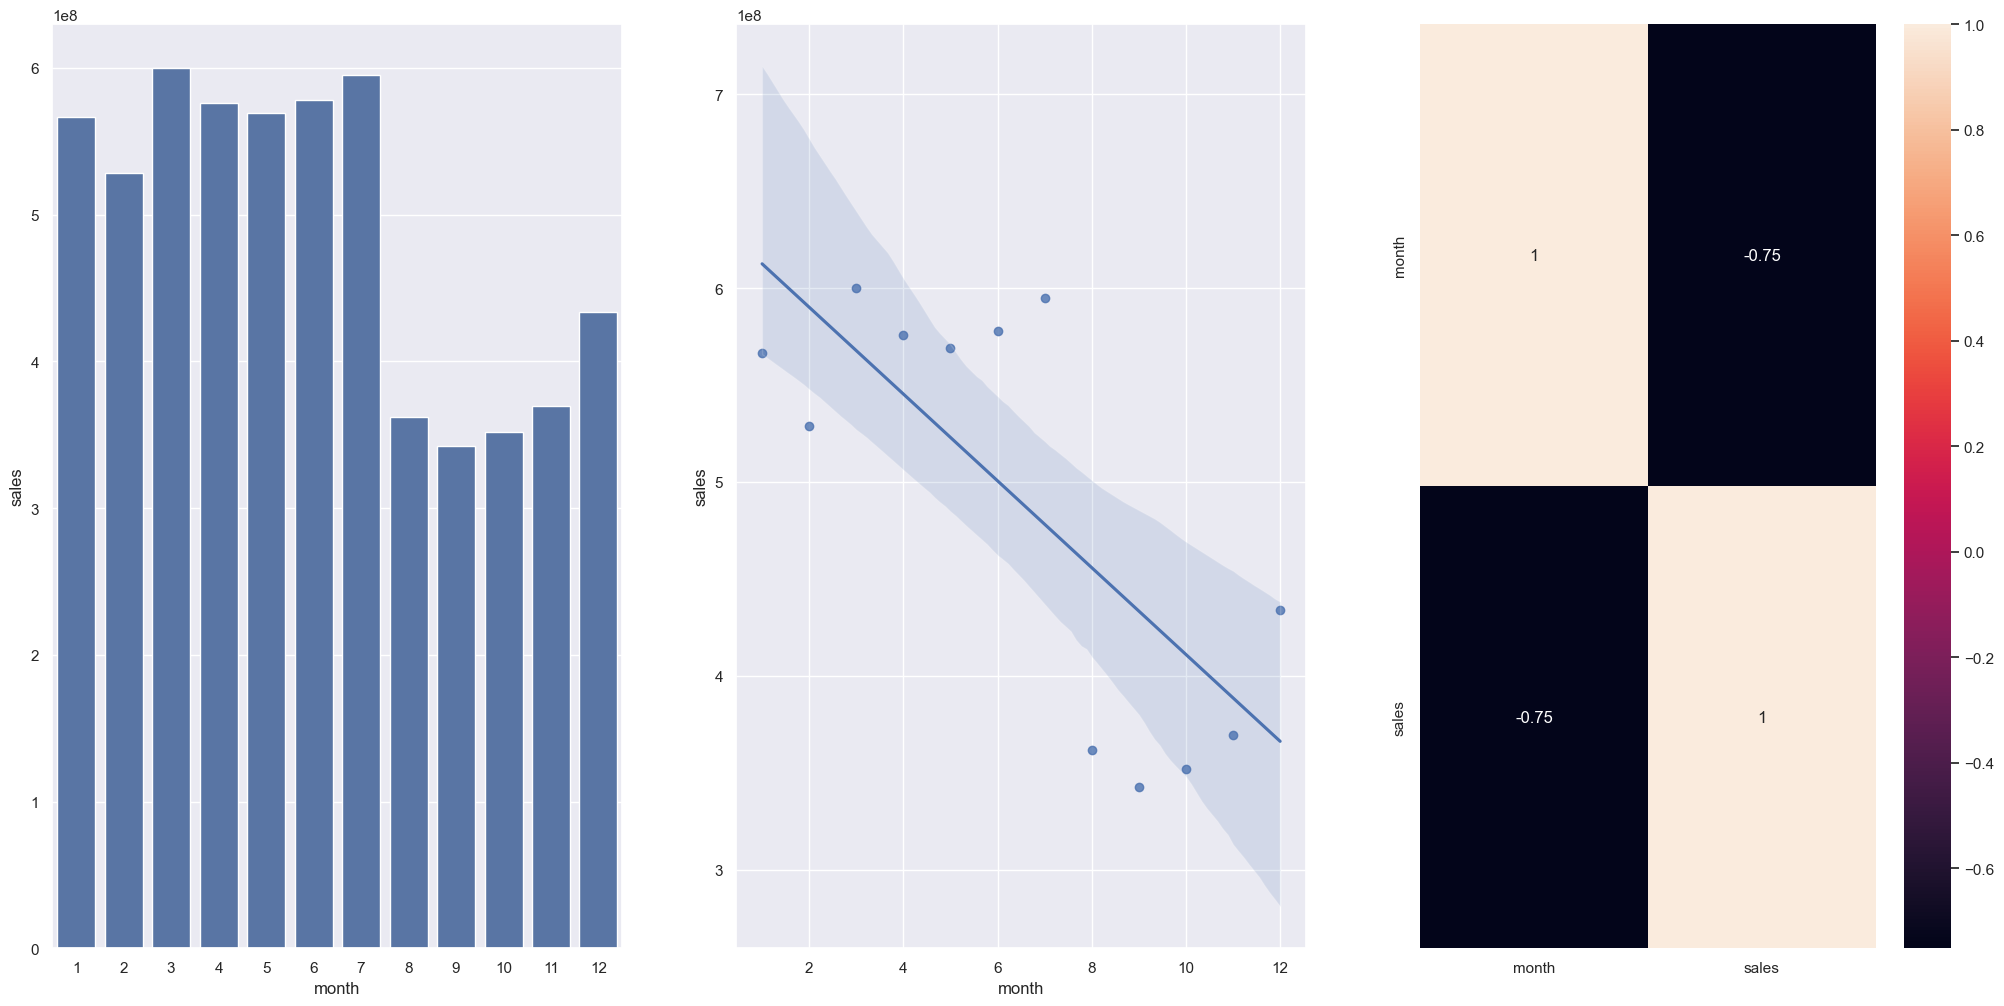

In [44]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**  Lojas vendem mais depois do dia 10 de cada mes.

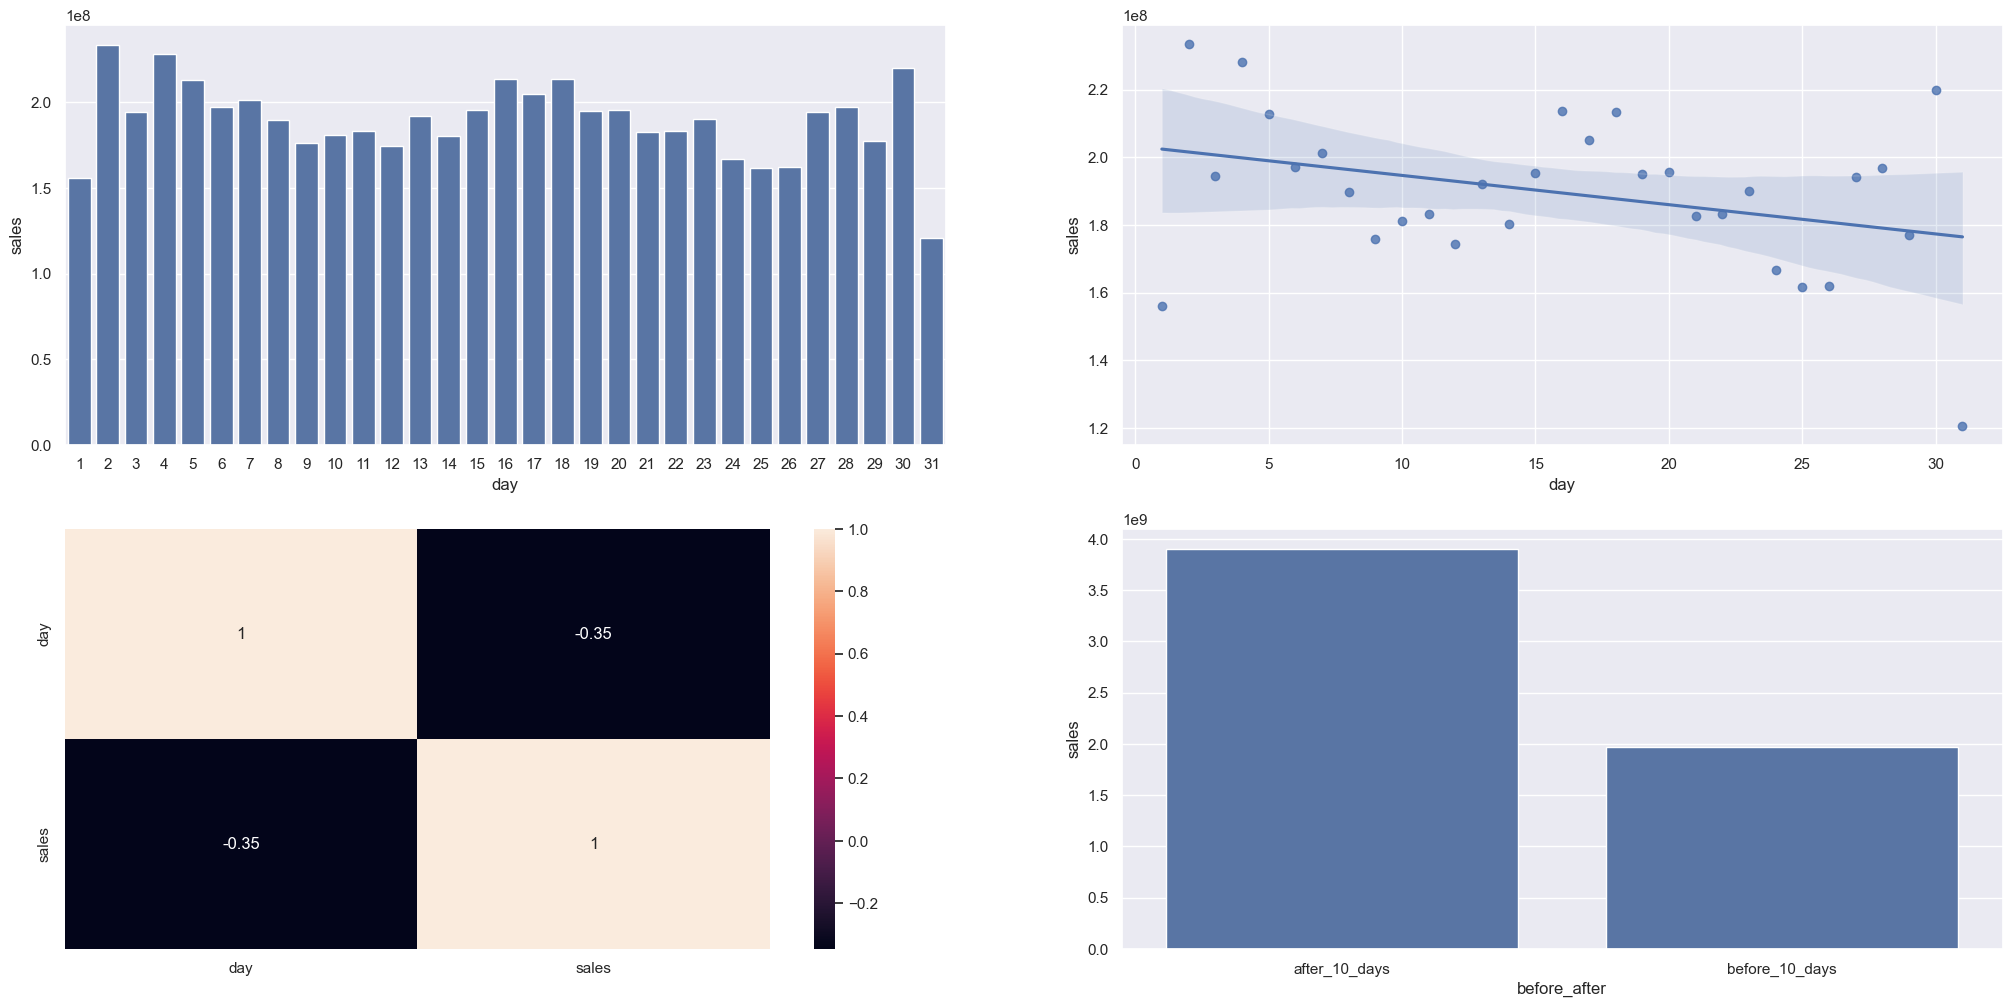

In [45]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**   Lojas vendem menos nos final de semana

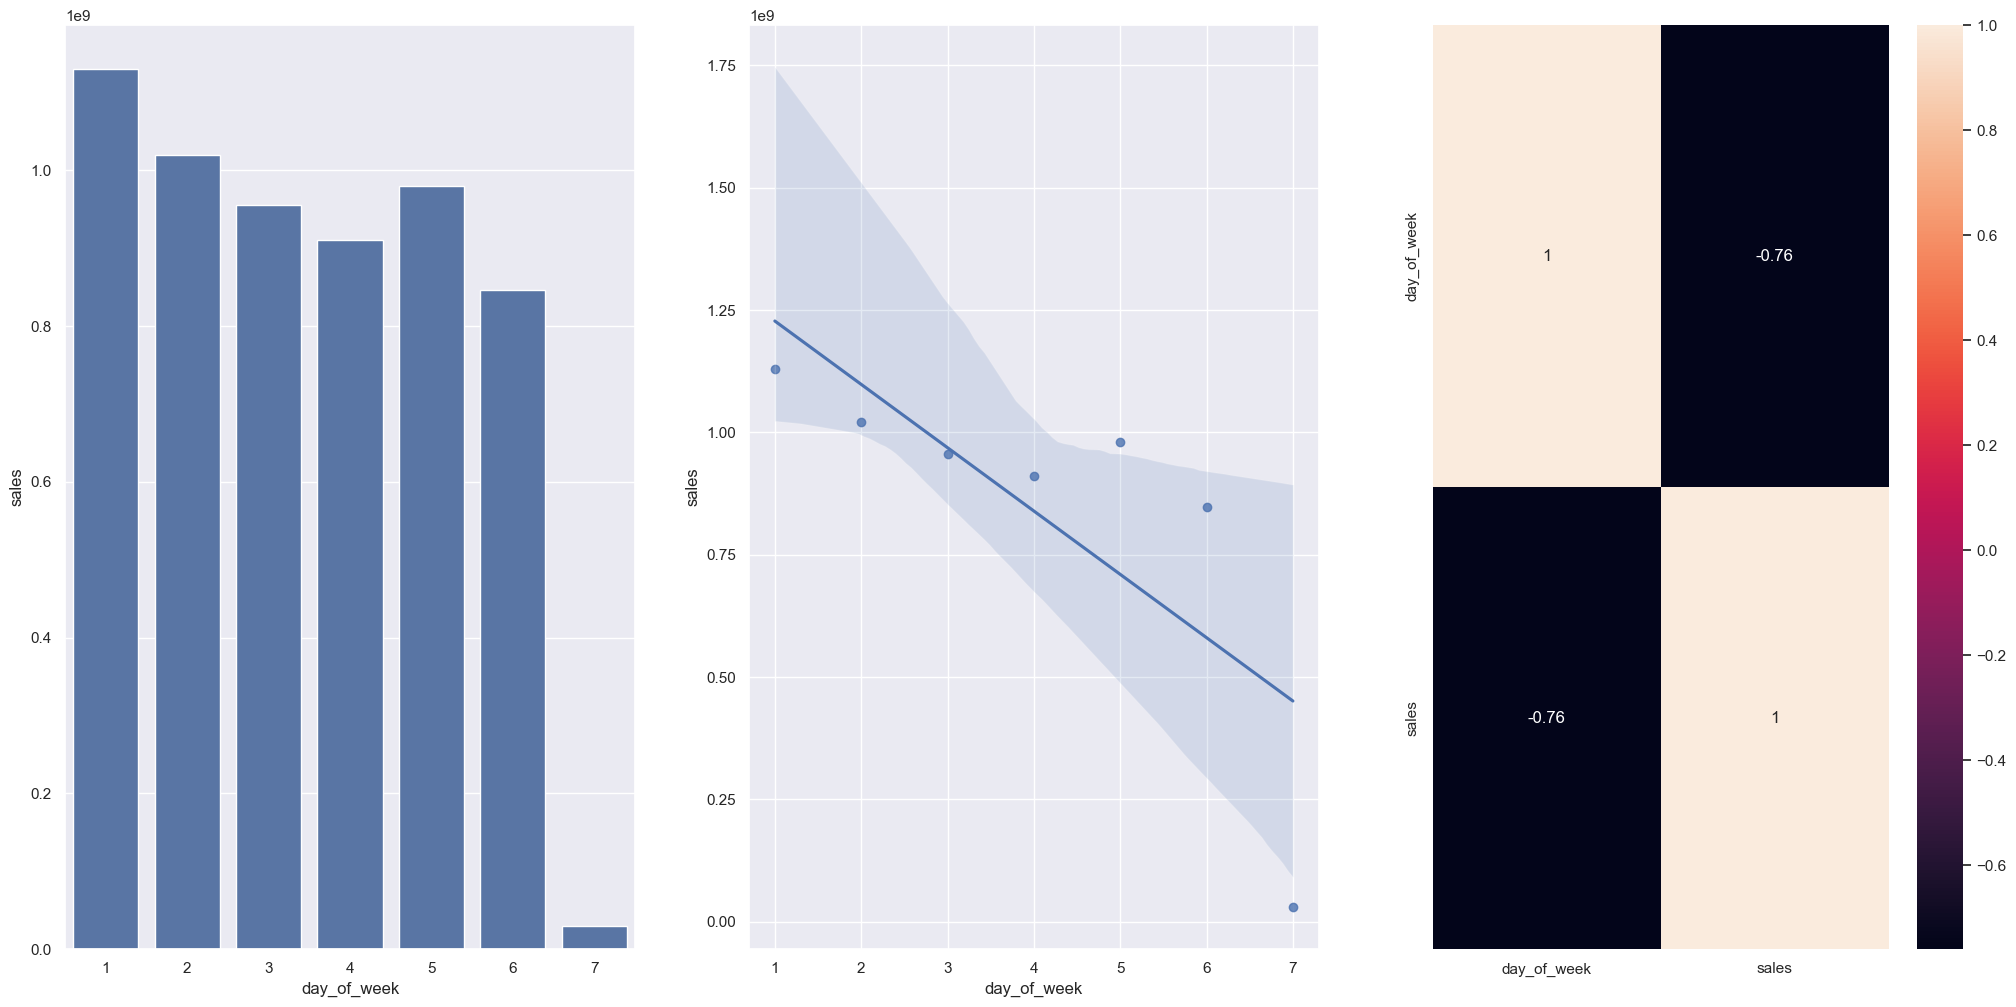

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H12.**  Lojas deveriam vender menos durante os feriados escolares
**FALSA**  Lojas vendem menos durante os feriadso escolares, except os meses de Julho e
Agosto.

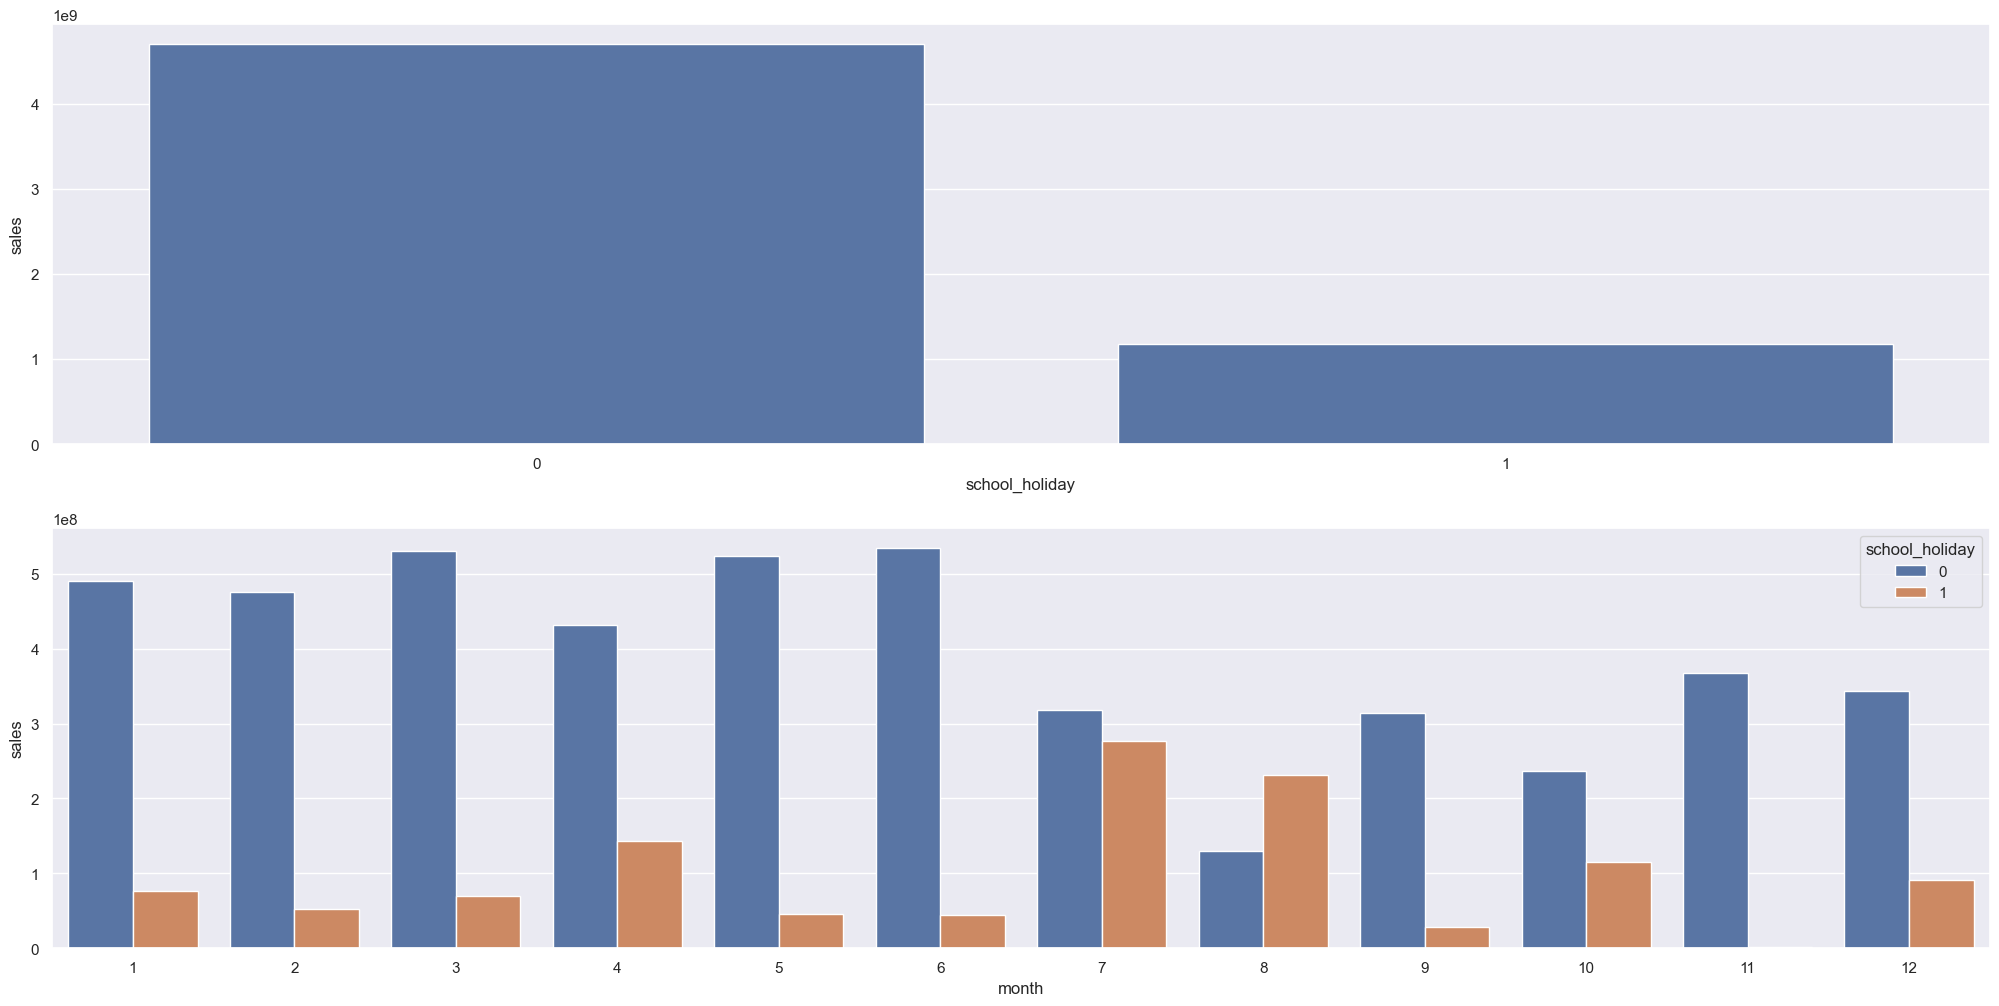

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### 4.2.1 Resumo das Hipoteses

In [48]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
# print( tabulate( tab, headers='firstrow' ) )


## 4.3. Analise Multivariada

### 4.3.1 Numercal attributes

<Axes: >

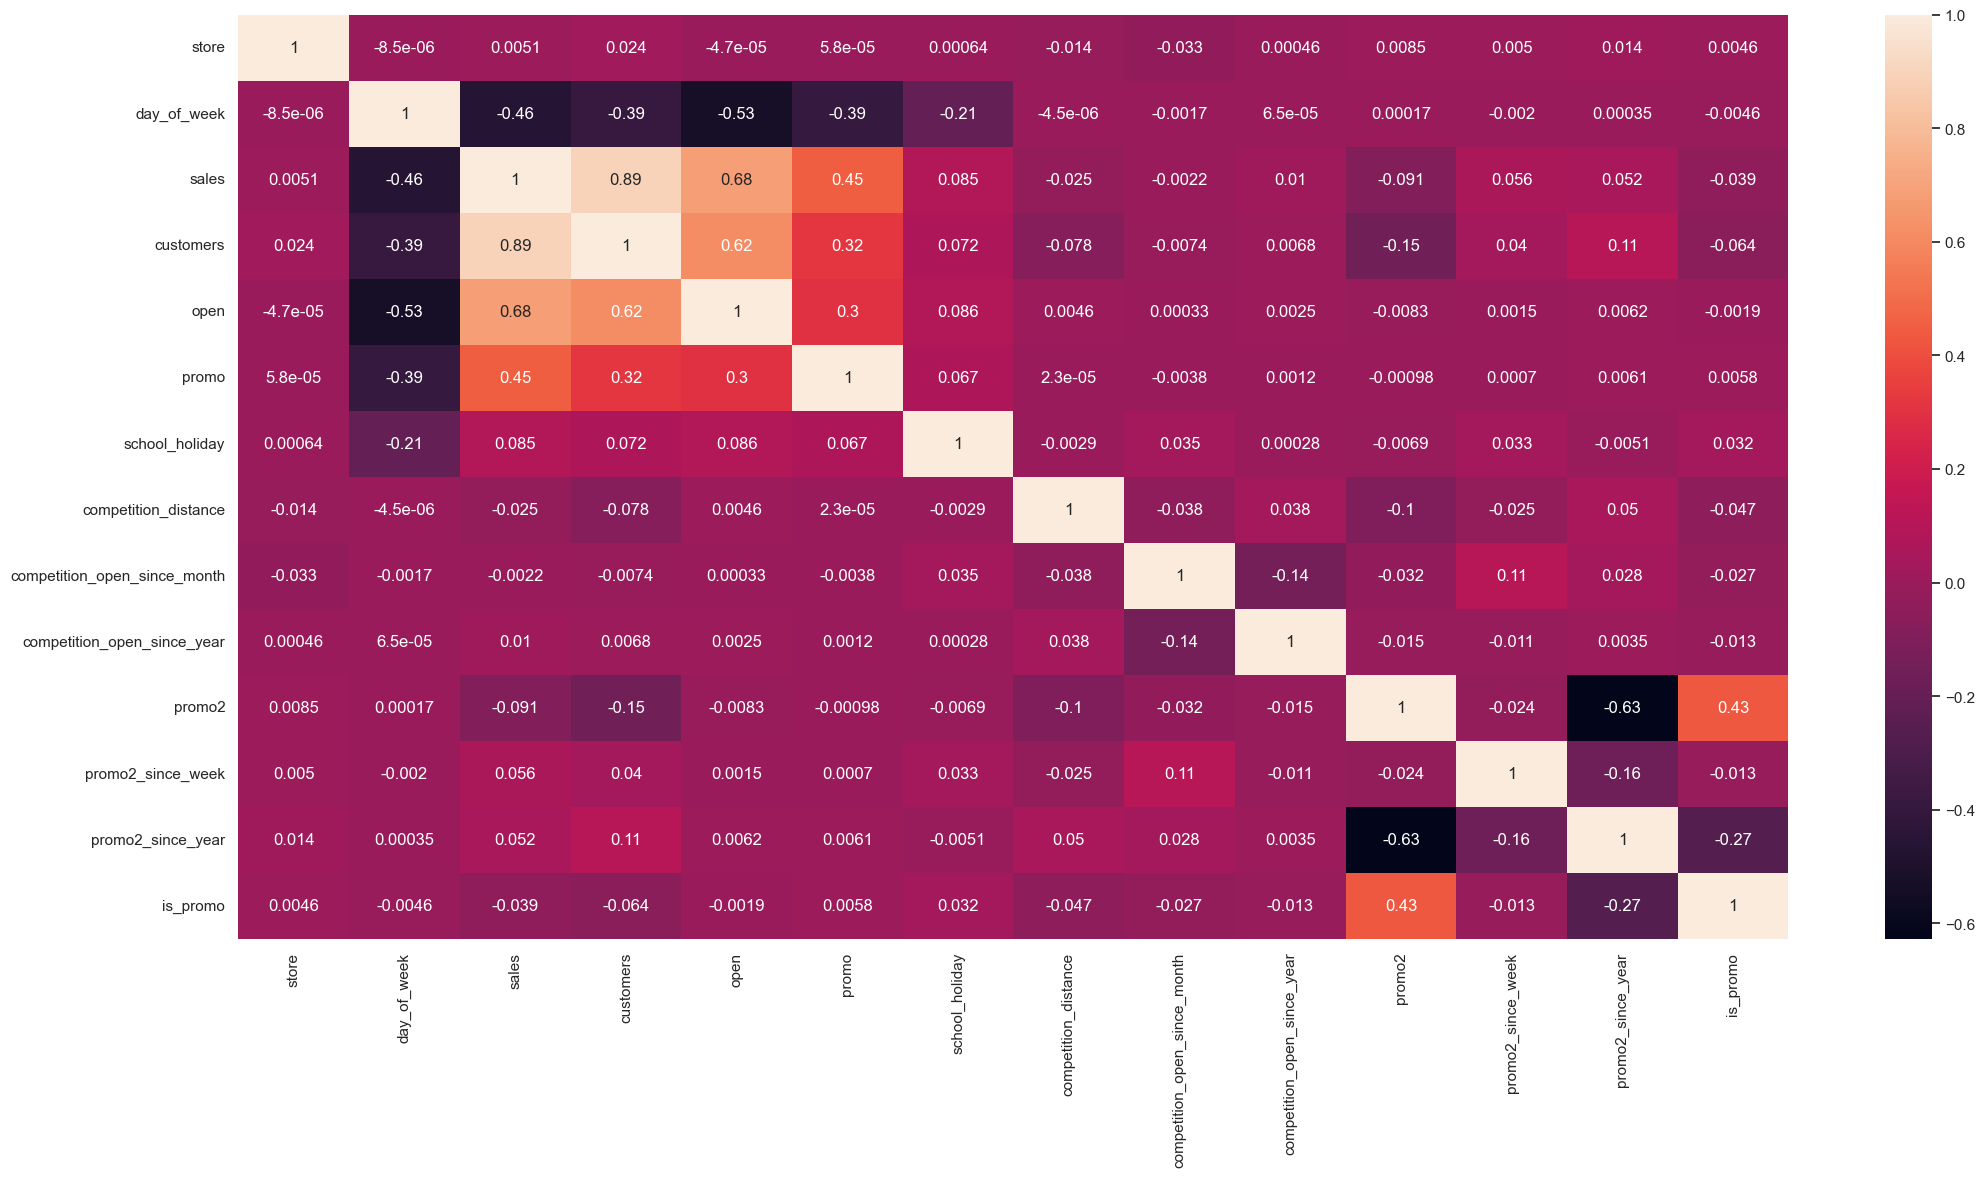

In [49]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical attributes

<Axes: >

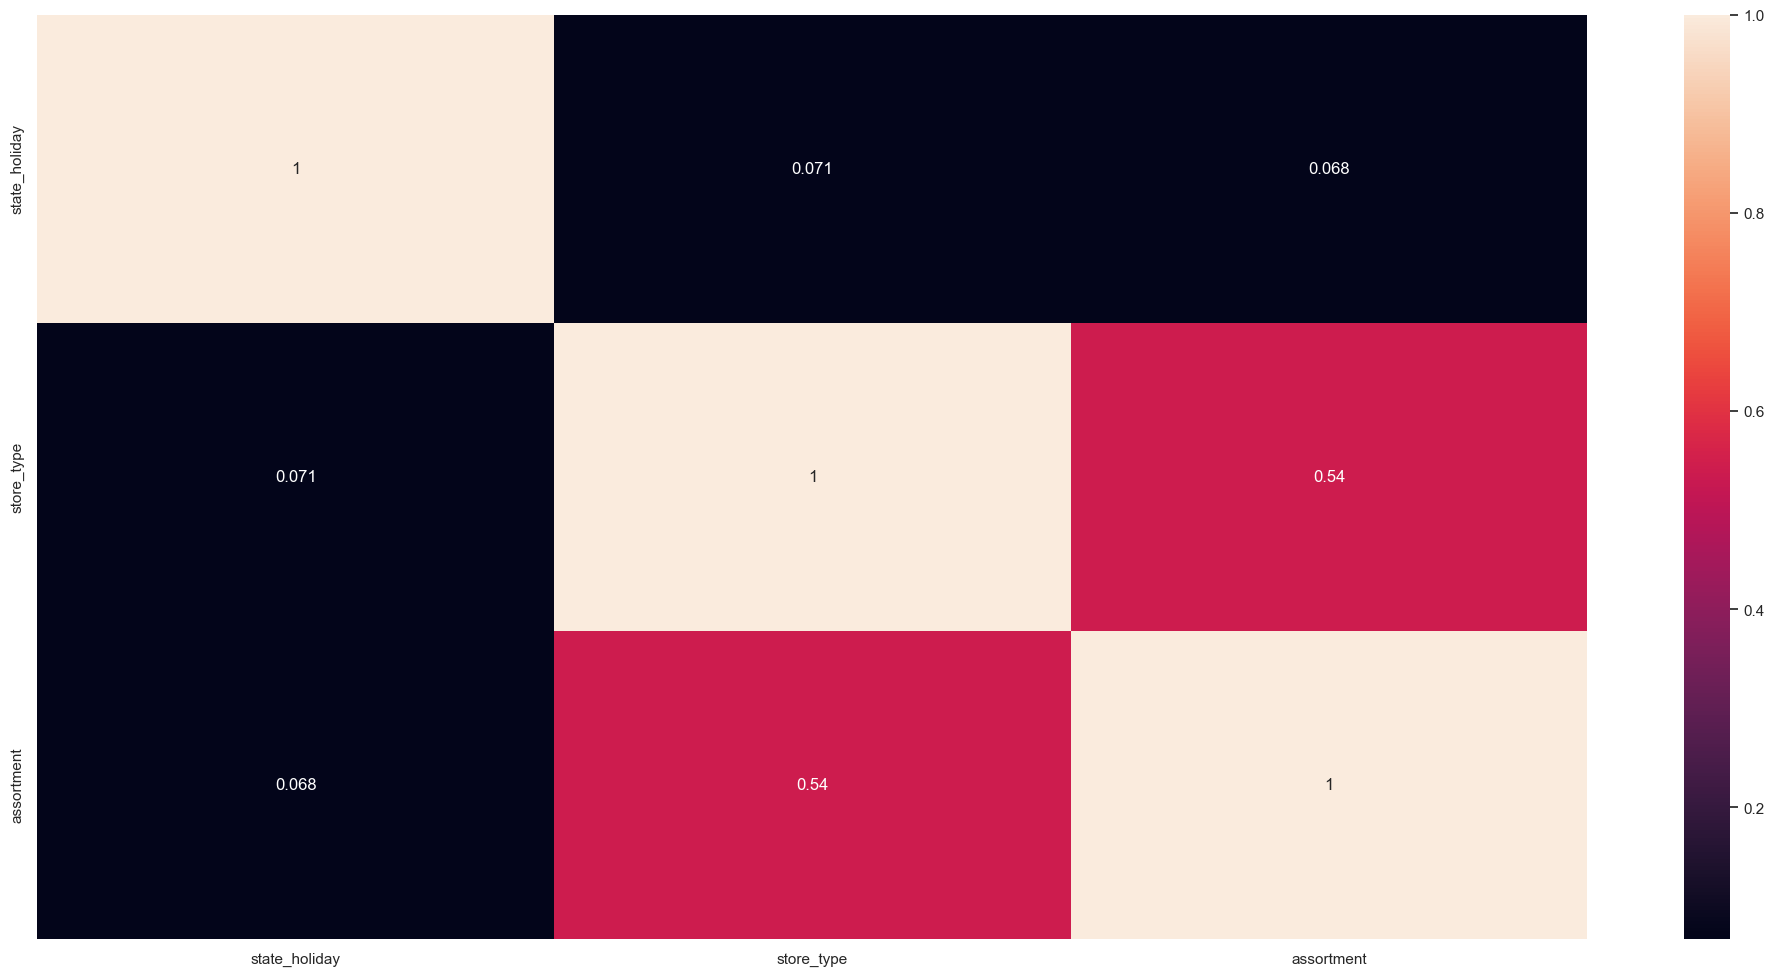

In [50]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )


# 5.0. PASSO 05 - DATA PREPARATION    

In [51]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )
# year
df5['year'] = mms.fit_transform(df5[['year']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )



## 5.3. Transformacao

### **5.3.1** Encoding

In [53]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### **5.3.2** Response Variable Transformation

In [54]:
df5['sales']= np.log1p(df5['sales'])

### **5.3.2** Nature Transformation

In [55]:
df5['store_type'] = df5['store_type'].astype( 'int64' )
df5['month'] = df5['month'].astype( 'int64' )
df5['day'] = df5['day'].astype( 'int64' )
df5['week_of_year'] = df5['day'].astype( 'int64' )


In [56]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )

In [57]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

# 6.0. PASSO 06 - FEATURE SELECTION

In [58]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [59]:
cols_drop=['week_of_year', 'day', 'month','day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [60]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7 )

Timestamp('2015-06-19 00:00:00')

In [61]:
#traing dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#traing dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Training Min Date: {}'.format(x_train['date'].min() ) )
print( 'Training Max Date: {}'.format(x_train['date'].max() ) )

print( '\nTraining Min Date: {}'.format(x_test['date'].min() ) )
print( 'Training Max Date: {}'.format(x_test['date'].max() ) )



Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Fefature Selector

In [63]:
# training and test dataset for boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegresor
rf = RandomForestRegressor(n_jobs=-1)

#define boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

KeyboardInterrupt: 

### 6.2. Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:,cols_selected]

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta )

### 6.3. Best Features from Boruta

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']
# columns to add
feat_to_add = ['date', 'sales']
# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta.extend( feat_to_add )


# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [ ]:
x_train = x_train[ cols_selected_boruta ]
x_test = x_test [ cols_selected_boruta ]

# Time Series Data Preparation
x_traning = x_train[cols_selected_boruta_full]

## 7.1. Average Model

In [ ]:
def mean_absolute_percent_error(y, yhat):
  return np.mean(np.abs((y - yhat) / y))


def ml_error( model_name, y, yhat):
  mae = mean_absolute_error( y, yhat )
  mape = mean_absolute_percent_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse }, index=[0])


In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

## 7.2. Linear Regression Model

In [ ]:
#model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
#model
lrr = Lasso(alpha = 0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

## 7.4. Random Forest Regressor

In [ ]:
#model
rf = RandomForestRegressor( n_estimators = 100, n_jobs=1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.4.1 Radom Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

## 7.5. XGBoost Regressor

In [ ]:
#model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_stimators = 100,
                              eta= 0.01,
                              max_depth= 10,
                              subsample = 0.7,
                              colsample_bytee= 0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error('EXBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1 - Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

### Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values( 'RMSE' )